# Système Multi-Agents avec Q-Learning - Démonstration Complète

Ce notebook présente l'ensemble des fonctionnalités du système d'ordonnancement hospitalier.

### Objectifs de la démonstration :
1. **Visualisation des données** : Planning initial et contraintes.
2. **Analyse de la Diversité** : Génération et affichage de la **Matrice des Distances** de l'EMP.
3. **Benchmark Slide 25** : Comparaison Métaheuristiques Seules vs SMA (Tableau généré).
4. **Benchmark Slide 26** : Comparaison Collaboration Amis vs Ennemis (Tableau généré).
5. **Visualisation Finale** : Courbes de convergence et Gantt optimisé.

In [ ]:
# 1. Configuration et Imports
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib

# Ajout du chemin racine
sys.path.insert(0, os.path.abspath(os.getcwd()))

# Imports du Core
from core.neighborhoods import NeighborhoodManager
from core.shared_memory import SharedMemoryPool, Solution
from core.agents import MultiAgentSystem, CollaborationMode
from visualization import plot_gantt, plot_convergence

# Reload modules to pick up recent changes
import core.environment
importlib.reload(core.environment)
from core.environment import *

# Configuration visuelle
plt.style.use('seaborn-v0_8-whitegrid')
random.seed(42)
np.random.seed(42)

print("✓ Environnement chargé avec succès.")

{1: {1: [(6, 2)], 2: [(6, 1)], 3: [(1, 1), (5, 1), (4, 1)], 4: [(5, 3), (1, 3), (2, 3)], 5: [(4, 3)]}, 2: {1: [(2, 3)], 2: [(2, 2), (6, 1)], 3: [(3, 2)], 4: [(6, 2)], 5: [(1, 2), (5, 3)]}, 3: {1: [(5, 3), (2, 1)], 2: [(3, 1)], 3: [(4, 2)], 4: [(2, 2), (3, 1)], 5: [(6, 3), (1, 3), (2, 1)]}, 4: {1: [(3, 1), (5, 3)], 2: [(2, 1)], 3: [(3, 1), (1, 3)], 4: [(2, 2), (4, 3)], 5: [(2, 3), (6, 3)]}, 5: {1: [(5, 2), (4, 1), (6, 1)], 2: [(1, 1)], 3: [(6, 2)], 4: [(4, 2), (5, 3)], 5: [(1, 3), (6, 2), (3, 1)]}, 6: {1: [(4, 1)], 2: [], 3: [(5, 3), (2, 1)], 4: [(6, 3), (5, 1)], 5: [(5, 3)]}, 7: {1: [], 2: [(1, 2), (6, 2)], 3: [(5, 1)], 4: [(1, 1), (5, 1)], 5: [(2, 1), (3, 3), (4, 3)]}, 8: {1: [(3, 2), (4, 3), (6, 2)], 2: [(1, 2)], 3: [(2, 1), (5, 1), (6, 3)], 4: [(1, 1)], 5: [(5, 1)]}, 9: {1: [(2, 1), (5, 3)], 2: [], 3: [(2, 2), (4, 1)], 4: [(4, 2), (3, 2), (6, 3)], 5: [(6, 2), (1, 3), (5, 2)]}, 10: {1: [(2, 1)], 2: [(2, 1), (4, 2)], 3: [(4, 3)], 4: [(5, 1), (1, 1), (6, 2)], 5: [(4, 1)]}}
{1: {1: [(6,

## 2. Analyse de la Diversité (Matrice des Distances)

L'Espace Mémoire Partagé (EMP) utilise une distance de Hamming adaptée pour maintenir la diversité. Visualisons cette matrice.

Génération de solutions pour la matrice de diversité...


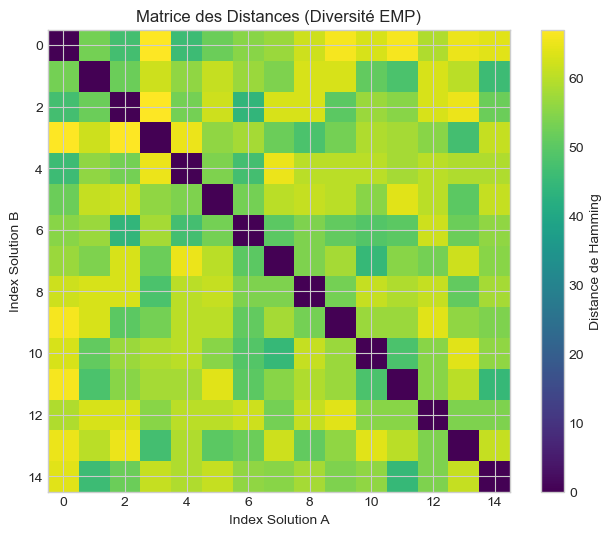

In [2]:
def plot_diversity_heatmap(emp, title="Matrice des Distances (Diversité EMP)"):
    """Génère une heatmap des distances entre les solutions de l'EMP."""
    solutions = emp.solutions
    n = len(solutions)
    
    if n < 2:
        print("Pas assez de solutions pour afficher la matrice.")
        return

    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # Calcul de la distance via la méthode interne de l'EMP
            dist = emp.calculate_distance(solutions[i].sequences, solutions[j].sequences)
            matrix[i, j] = dist

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(cax, label='Distance de Hamming')
    
    ax.set_title(title)
    ax.set_xlabel("Index Solution A")
    ax.set_ylabel("Index Solution B")
    plt.show()

# Simulation : Remplissage de l'EMP avec des solutions aléatoires
env = create_default_environment()
temp_emp = SharedMemoryPool(max_size=20, min_distance=0, diversity_threshold=1.0)

print("Génération de solutions pour la matrice de diversité...")
for i in range(15):
    sol = env.build_initial_solution(random_order=True)
    fit, _, _ = env.evaluate(sol)
    temp_emp.insert(Solution(sol, fit))

plot_diversity_heatmap(temp_emp)

## 3. Benchmark - Tableau 1 (Slide 25)
**Comparaison : Métaheuristiques Seules vs SMA**

Nous lançons des exécutions courtes (50 itérations) pour générer les données du tableau.

In [3]:
def run_quick_scenario(name, mode, q_learn, agents_config, iterations=50):
    """Exécute un scénario et retourne le meilleur makespan."""
    sys_local = MultiAgentSystem(env, mode=mode, use_qlearning=q_learn)
    for type_ag, name_ag, params in agents_config:
        sys_local.add_agent(type_ag, name_ag, **params)
    
    start = time.time()
    best = sys_local.run(n_iterations=iterations, verbose=False)
    dt = time.time() - start
    return best.fitness if best else float('inf'), dt

ITERATIONS = 50
results_table_1 = {}

print(f"Lancement du Benchmark Tableau 1 ({ITERATIONS} itérations par run)...")

# 1. AG Solo
res, t = run_quick_scenario("AG Solo", CollaborationMode.ENEMIES, False, 
                            [('genetic', 'AG', {'population_size': 20})], ITERATIONS)
results_table_1['AG'] = res

# 2. Tabou Solo
res, t = run_quick_scenario("Tabou Solo", CollaborationMode.ENEMIES, False, 
                            [('tabu', 'Tabu', {'tabu_tenure': 10})], ITERATIONS)
results_table_1['Tabu'] = res

# 3. RS Solo
res, t = run_quick_scenario("RS Solo", CollaborationMode.ENEMIES, False, 
                            [('sa', 'RS', {'initial_temp': 100})], ITERATIONS)
results_table_1['RS'] = res

# Configuration SMA (Trio)
trio_config = [
    ('genetic', 'AG', {'population_size': 15}),
    ('tabu', 'Tabu', {'tabu_tenure': 10}),
    ('sa', 'RS', {'initial_temp': 100})
]

# 4. SMA No Learning
res, t = run_quick_scenario("SMA NoLearn", CollaborationMode.FRIENDS, False, trio_config, ITERATIONS)
results_table_1['SMA_NoLearn'] = res

# 5. SMA Learning
res, t = run_quick_scenario("SMA Learn", CollaborationMode.FRIENDS, True, trio_config, ITERATIONS)
results_table_1['SMA_Learn'] = res

# Affichage du Tableau 1
print("\n" + "="*75)
print("  TABLEAU 1 : RÉSULTATS SANS/AVEC COLLABORATION (Inspiré Slide 25)")
print("="*75)
print(f"{'Configuration':<20} | {'Makespan Moyen (Score)':<25} | {'Gain Relatif'}")
print("-"*75)
base = results_table_1['AG']
for key, val in results_table_1.items():
    gain = ((base - val) / base) * 100
    print(f"{key:<20} | {val:<25.1f} | {gain:+.2f}%")
print("="*75)

Lancement du Benchmark Tableau 1 (50 itérations par run)...

  TABLEAU 1 : RÉSULTATS SANS/AVEC COLLABORATION (Inspiré Slide 25)
Configuration        | Makespan Moyen (Score)    | Gain Relatif
---------------------------------------------------------------------------
AG                   | 35.0                      | +0.00%
Tabu                 | 35.0                      | +0.00%
RS                   | 35.0                      | +0.00%
SMA_NoLearn          | 35.0                      | +0.00%
SMA_Learn            | 35.0                      | +0.00%


## 4. Benchmark - Tableau 2 (Slide 26)
**Comparaison : Mode AMIS vs Mode ENNEMIS**

Nous comparons l'efficacité de la collaboration (Partage EMP) vs la compétition (Pool Élite).

In [4]:
print(f"Lancement du Benchmark Tableau 2 (Comparaison Modes)...")

# Configuration pour récupérer l'historique de convergence
mas_amis = MultiAgentSystem(env, mode=CollaborationMode.FRIENDS, use_qlearning=True)
for type_ag, name_ag, params in trio_config:
    mas_amis.add_agent(type_ag, name_ag, **params)

mas_ennemis = MultiAgentSystem(env, mode=CollaborationMode.ENEMIES, use_qlearning=True)
for type_ag, name_ag, params in trio_config:
    mas_ennemis.add_agent(type_ag, name_ag + "_E", **params)

# Exécution
best_amis = mas_amis.run(n_iterations=100, verbose=False)
best_ennemis = mas_ennemis.run(n_iterations=100, verbose=False)

# Affichage Tableau 2
score_amis = best_amis.fitness
score_ennemis = best_ennemis.fitness

print("\n" + "="*60)
print("  TABLEAU 2 : AMIS vs ENNEMIS (Inspiré Slide 26)")
print("="*60)
print(f"{'Mode':<20} | {'Meilleur Makespan':<20} | {'Amélioration'}")
print("-"*60)
print(f"{'Mode ENNEMIS':<20} | {score_ennemis:<20.1f} | Reference")
gain_collab = ((score_ennemis - score_amis) / score_ennemis) * 100
print(f"{'Mode AMIS':<20} | {score_amis:<20.1f} | {gain_collab:+.2f}%")
print("="*60)

Lancement du Benchmark Tableau 2 (Comparaison Modes)...

  TABLEAU 2 : AMIS vs ENNEMIS (Inspiré Slide 26)
Mode                 | Meilleur Makespan    | Amélioration
------------------------------------------------------------
Mode ENNEMIS         | 35.0                 | Reference
Mode AMIS            | 35.0                 | +0.00%


## 5. Visualisations Avancées : Q-Table Heatmap et Matrice de Diversité

Visualisation du processus d'apprentissage par renforcement (Q-Learning) et de la diversité des solutions dans l'EMP.



VISUALISATIONS DE CONVERGENCE


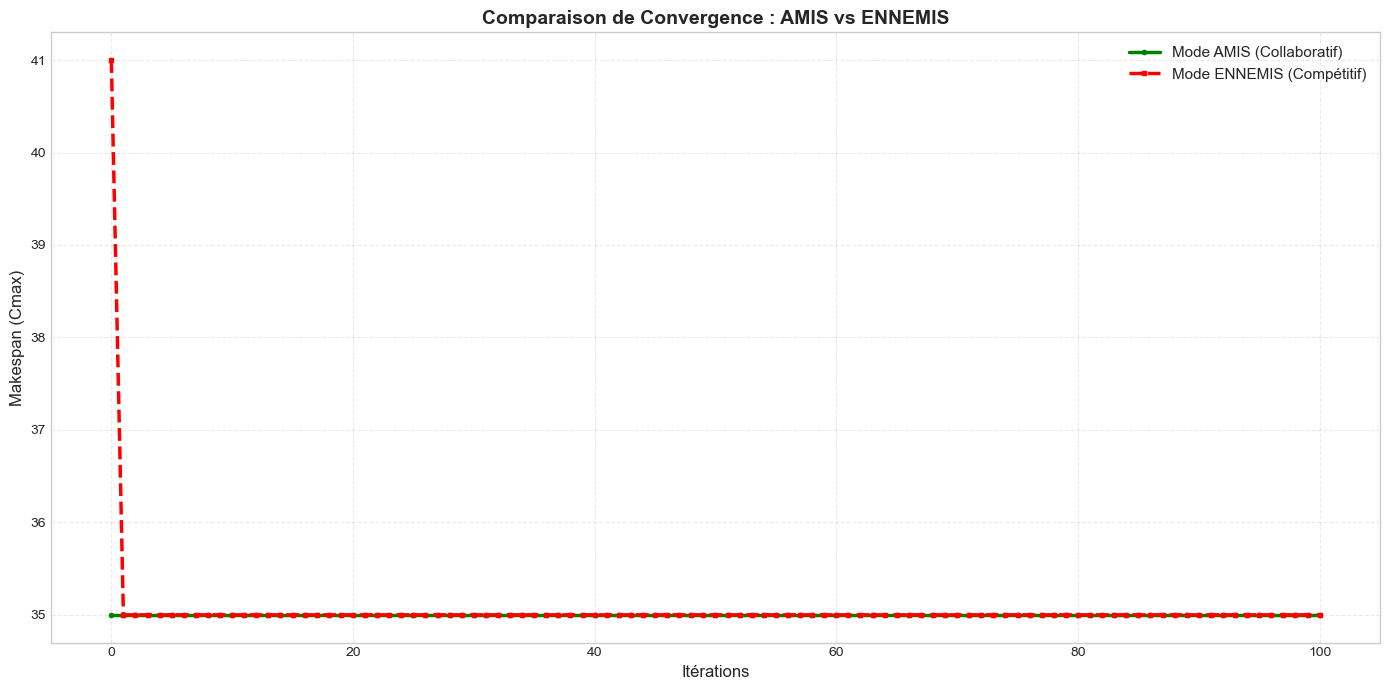


GANTT FINAL - MEILLEURE SOLUTION (MODE AMIS)
Makespan final (Cmax) : 35 slots (= 175 minutes)


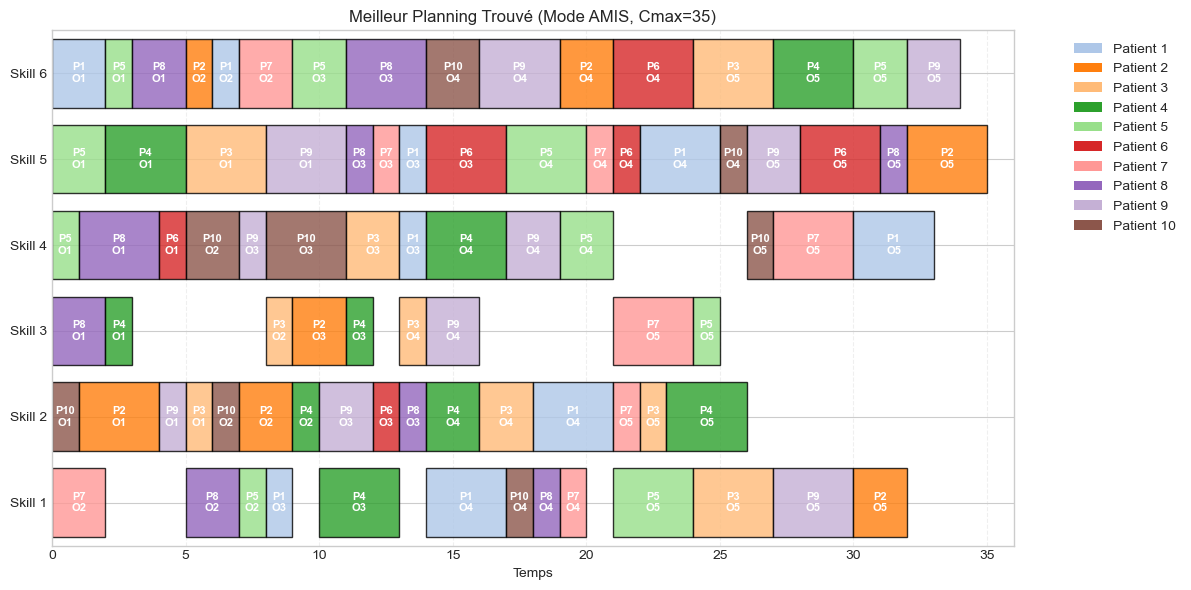

In [5]:
def plot_q_table_heatmap(agent, title="Q-Table Learning Visualization"):
    """
    Affiche la heatmap de la Q-Table pour visualiser le Processus Markovien.
    Lignes: États (Amélioration, Stagnation, Dégradation)
    Colonnes: Actions (Voisinages C, E)
    """
    # Récupération de la Q-table depuis l'agent
    if not hasattr(agent, 'q_selector') or agent.q_selector is None:
        print(f"L'agent {agent.agent_id} n'utilise pas l'apprentissage Q.")
        return

    q_agent = agent.q_selector.q_agent
    q_table_dict = q_agent.get_q_table_formatted()
    
    states = sorted(q_table_dict.keys())
    actions = list(q_table_dict[states[0]].keys()) if states else []
    
    if not states or not actions:
        print("Q-table vide ou non disponible.")
        return
    
    # Construction de la matrice
    matrix = np.zeros((len(states), len(actions)))
    for i, s in enumerate(states):
        for j, a in enumerate(actions):
            matrix[i, j] = q_table_dict[s][a]

    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.imshow(matrix, cmap='coolwarm', aspect='auto')
    fig.colorbar(cax, label='Q-Value')

    # Labels
    ax.set_xticks(range(len(actions)))
    ax.set_xticklabels(actions, fontsize=12, fontweight='bold')
    ax.set_yticks(range(len(states)))
    ax.set_yticklabels(states, fontsize=12)
    
    # Valeurs dans les cases
    for i in range(len(states)):
        for j in range(len(actions)):
            val = matrix[i, j]
            text_color = "white" if abs(val) > np.max(np.abs(matrix)) / 2 else "black"
            ax.text(j, i, f"{val:.3f}", ha="center", va="center", color=text_color, fontsize=11, fontweight='bold')

    ax.set_title(f"{title} - Agent {agent.agent_id}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Actions (Voisinages)", fontsize=12)
    ax.set_ylabel("États Markoviens", fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_distance_matrix(emp, title="Matrice des Distances (EMP)"):
    """Affiche la matrice des distances des solutions en mémoire partagée."""
    solutions = emp.solutions
    n = len(solutions)
    if n < 2:
        print(f"Pas assez de solutions pour la matrice ({n} solutions).")
        return
        
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # Distance de Hamming entre les sequences (Solution objects)
            sol_i = solutions[i].sequences
            sol_j = solutions[j].sequences
            dist = emp.calculate_distance(sol_i, sol_j)
            matrix[i, j] = dist
            
    fig, ax = plt.subplots(figsize=(8, 7))
    cax = ax.imshow(matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(cax, label='Distance de Hamming')
    
    # Annotations
    for i in range(n):
        for j in range(n):
            val = int(matrix[i, j])
            color = "white" if val < np.max(matrix) / 2 else "black"
            ax.text(j, i, str(val), ha="center", va="center", color=color, fontsize=9, fontweight='bold')

    ax.set_title(f"{title} - {n} solutions", fontsize=14, fontweight='bold')
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xlabel("Index Solution", fontsize=11)
    ax.set_ylabel("Index Solution", fontsize=11)
    plt.tight_layout()
    plt.show()

# 1. Courbes de convergence Comparatives
print("\n" + "="*80)
print("VISUALISATIONS DE CONVERGENCE")
print("="*80)

plt.figure(figsize=(14, 7))

# Récupération de l'historique du meilleur agent de chaque système
hist_amis = None
hist_ennemis = None

for agent_id, agent in mas_amis.agents.items():
    if hasattr(agent, 'fitness_history') and agent.fitness_history:
        hist_amis = agent.fitness_history
        break

for agent_id, agent in mas_ennemis.agents.items():
    if hasattr(agent, 'fitness_history') and agent.fitness_history:
        hist_ennemis = agent.fitness_history
        break

if hist_amis and hist_ennemis:
    plt.plot(hist_amis, label='Mode AMIS (Collaboratif)', color='green', linewidth=2.5, marker='o', markersize=3)
    plt.plot(hist_ennemis, label='Mode ENNEMIS (Compétitif)', color='red', linestyle='--', linewidth=2.5, marker='s', markersize=3)
    plt.title("Comparaison de Convergence : AMIS vs ENNEMIS", fontsize=14, fontweight='bold')
    plt.xlabel("Itérations", fontsize=12)
    plt.ylabel("Makespan (Cmax)", fontsize=12)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Historiques de convergence non disponibles.")

# 2. Gantt Final (Meilleure solution trouvée - Mode AMIS)
print("\n" + "="*80)
print("GANTT FINAL - MEILLEURE SOLUTION (MODE AMIS)")
print("="*80)

try:
    if best_amis and best_amis.sequences:
        final_cmax, final_times, _ = env.evaluate(best_amis.sequences, return_schedule=True)
        print(f"Makespan final (Cmax) : {final_cmax} slots (= {final_cmax * 5} minutes)")
        plot_gantt(
            final_times, env.skills, env.num_patients,
            title=f"Meilleur Planning Trouvé (Mode AMIS, Cmax={final_cmax})"
        )
    else:
        print("Pas de solution valide trouvée pour le mode AMIS.")
except Exception as e:
    print(f"Erreur lors de l'affichage du Gantt final: {e}")



VISUALISATIONS AVANCÉES : DIVERSITÉ ET APPRENTISSAGE

> 6.1 Matrice de Diversité de la Mémoire Partagée (EMP) - Mode AMIS


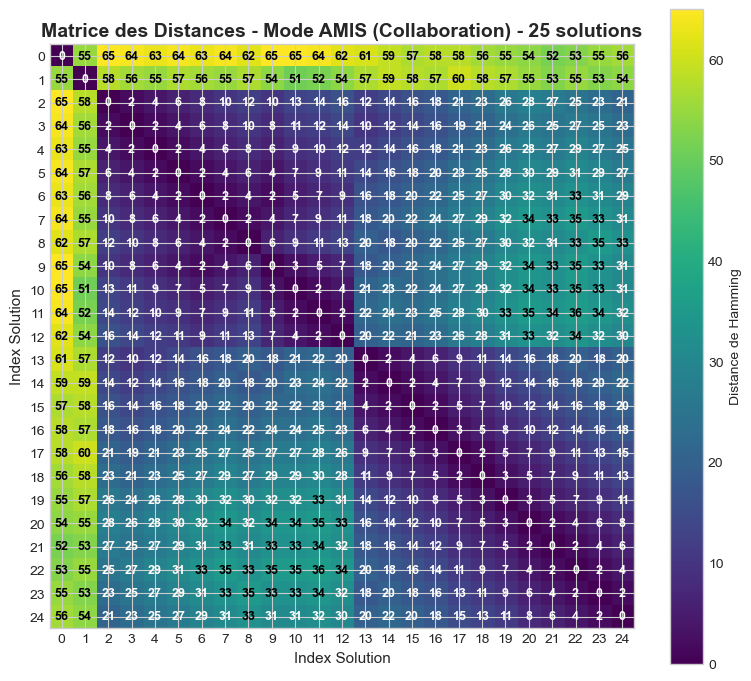


> 6.2 Matrice de Diversité de la Mémoire Partagée (EMP) - Mode ENNEMIS


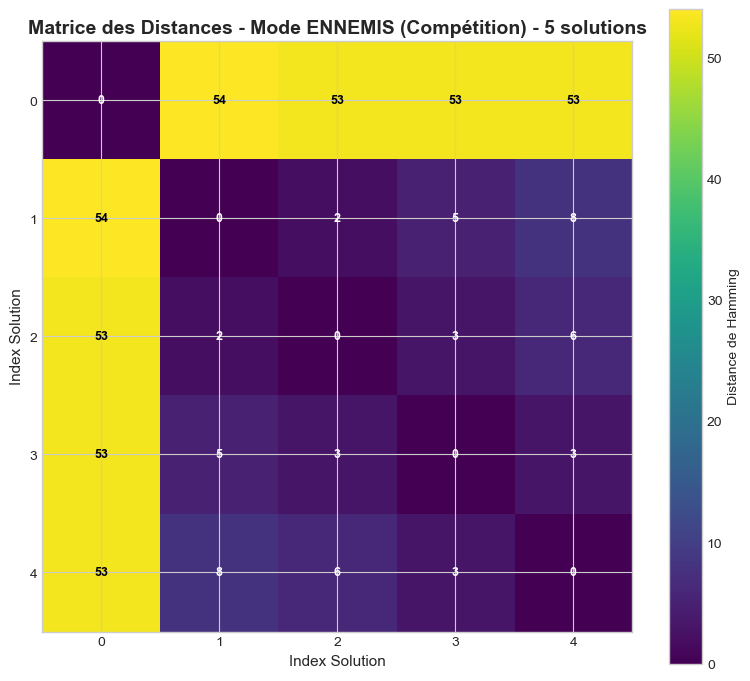


> 6.3 Visualisation des Q-Tables d'apprentissage - Mode AMIS
Agents détectés (Mode AMIS): ['AG', 'Tabu', 'RS']

  Affichage Q-Learning pour Agent AG (Mode AMIS):


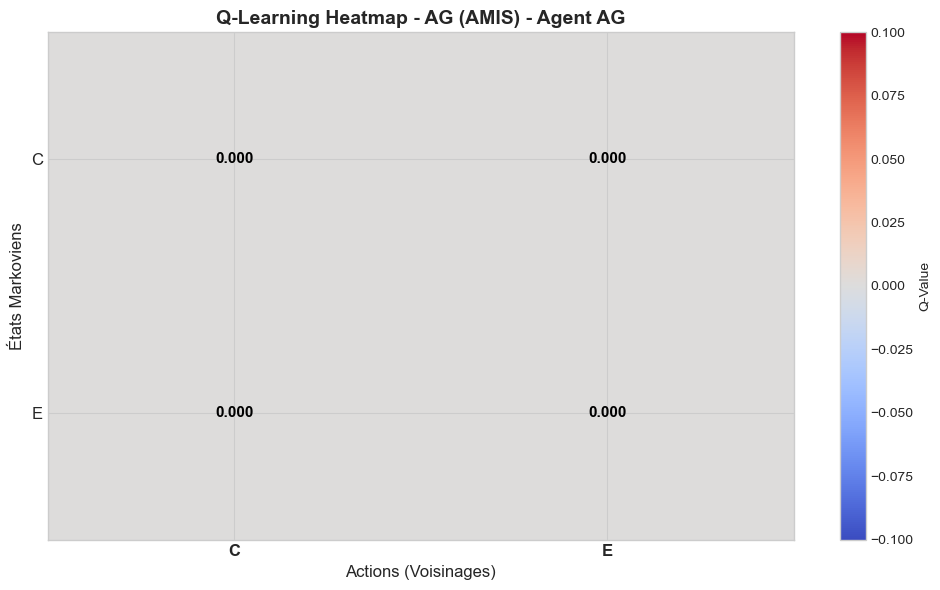


  Affichage Q-Learning pour Agent Tabu (Mode AMIS):


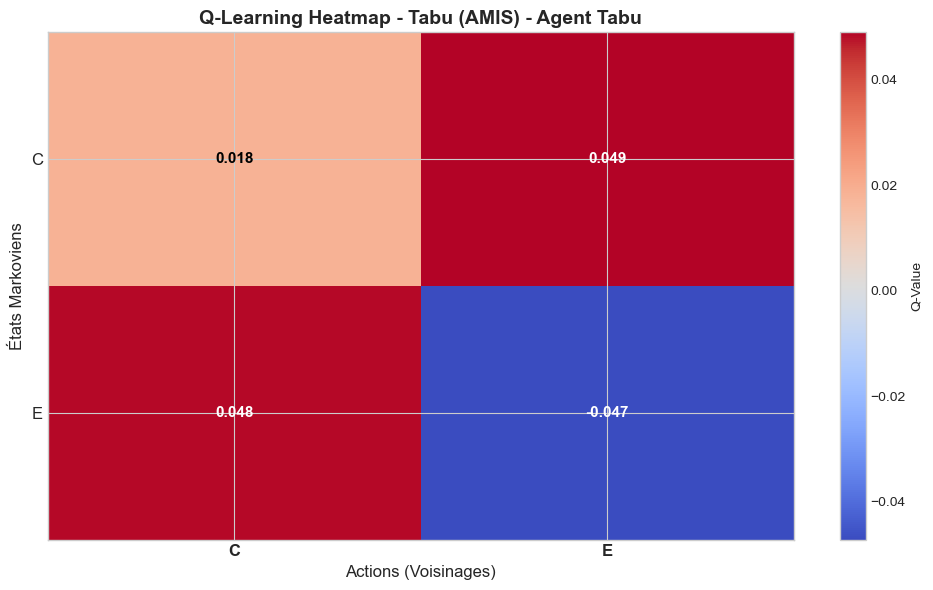


  Affichage Q-Learning pour Agent RS (Mode AMIS):


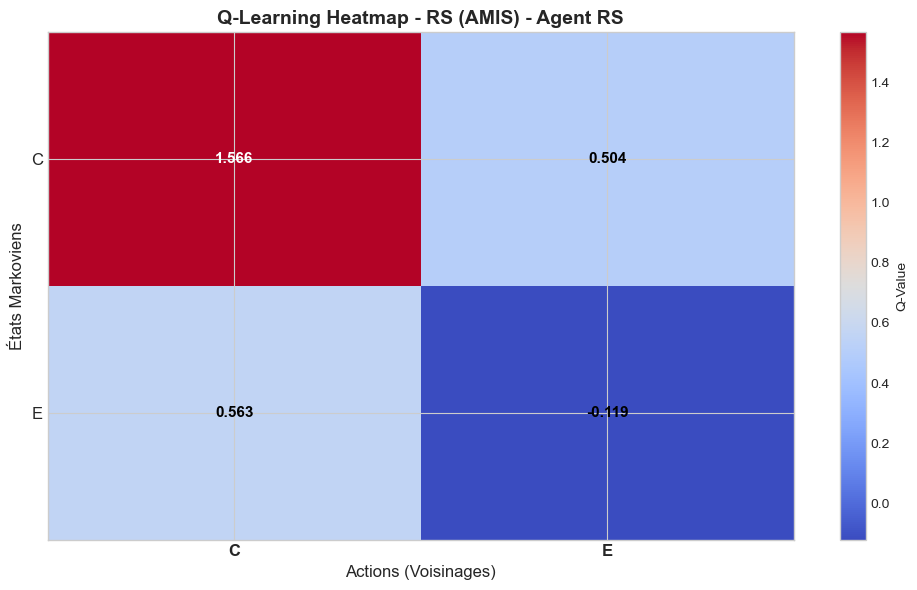


> 6.4 Visualisation des Q-Tables d'apprentissage - Mode ENNEMIS
Agents détectés (Mode ENNEMIS): ['AG_E', 'Tabu_E', 'RS_E']

  Affichage Q-Learning pour Agent AG_E (Mode ENNEMIS):


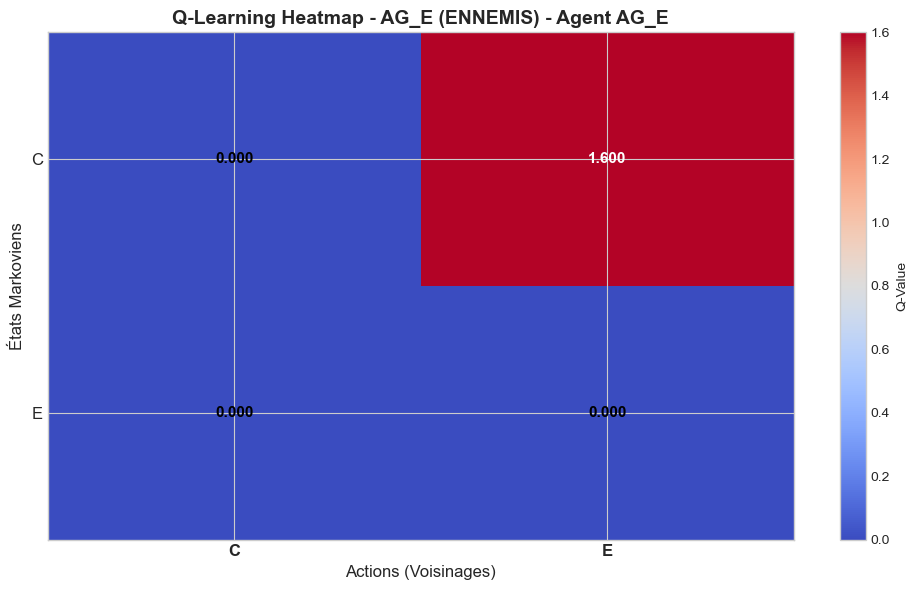


  Affichage Q-Learning pour Agent Tabu_E (Mode ENNEMIS):


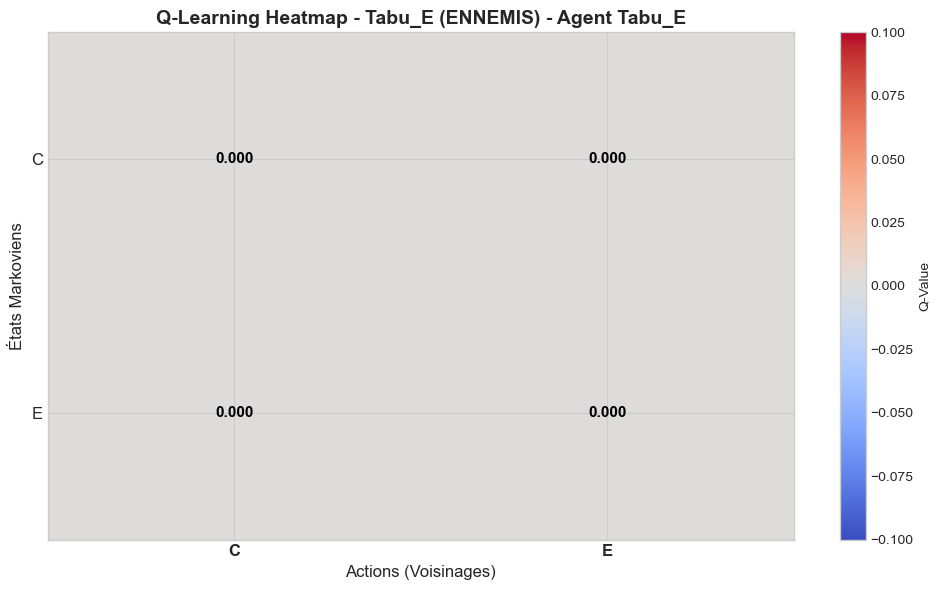


  Affichage Q-Learning pour Agent RS_E (Mode ENNEMIS):


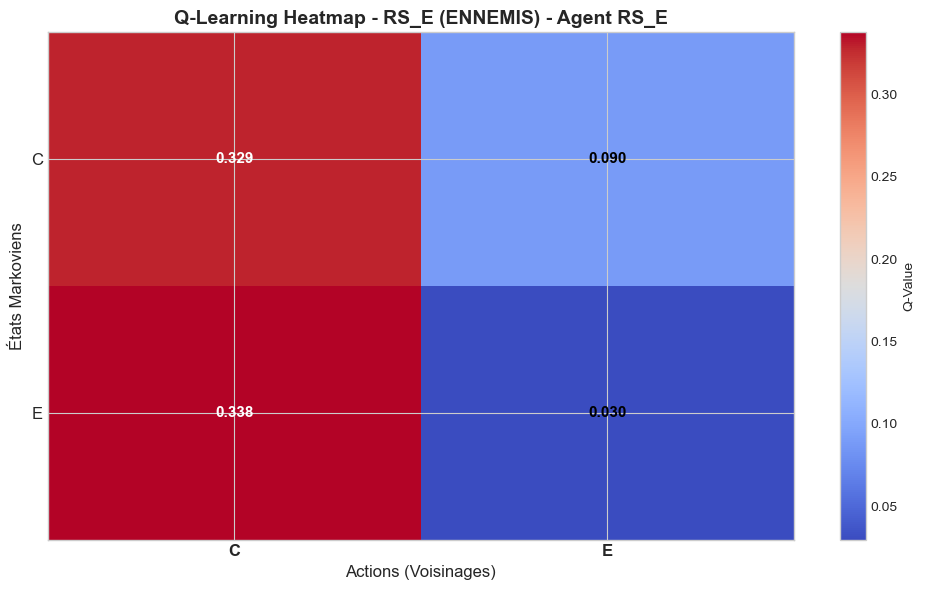


VISUALISATIONS TERMINÉES AVEC SUCCÈS

> RÉSUMÉ DES STATISTIQUES

  Mode AMIS (Collaboration):
    - Meilleur fitness: 35
    - Nombre de solutions en mémoire: 25
    - Insertions réussies: 25
    - Rejets (doublon): 116

  Mode ENNEMIS (Compétition):
    - Meilleur fitness: 35
    - Nombre de solutions en mémoire: 5
    - Insertions réussies: 5
    - Rejets (doublon): 101



In [6]:
print("\n" + "="*80)
print("VISUALISATIONS AVANCÉES : DIVERSITÉ ET APPRENTISSAGE")
print("="*80)

# 6.1 Matrice de Diversité (EMP) - Mode AMIS
print("\n> 6.1 Matrice de Diversité de la Mémoire Partagée (EMP) - Mode AMIS")
try:
    if hasattr(mas_amis, 'shared_memory') and mas_amis.shared_memory.solutions:
        plot_distance_matrix(mas_amis.shared_memory, title="Matrice des Distances - Mode AMIS (Collaboration)")
    else:
        print("EMP vide pour le mode AMIS.")
except Exception as e:
    print(f"Erreur affichage matrice AMIS: {e}")

# 6.2 Matrice de Diversité (EMP) - Mode ENNEMIS
print("\n> 6.2 Matrice de Diversité de la Mémoire Partagée (EMP) - Mode ENNEMIS")
try:
    if hasattr(mas_ennemis, 'shared_memory') and mas_ennemis.shared_memory.solutions:
        plot_distance_matrix(mas_ennemis.shared_memory, title="Matrice des Distances - Mode ENNEMIS (Compétition)")
    else:
        print("EMP vide pour le mode ENNEMIS.")
except Exception as e:
    print(f"Erreur affichage matrice ENNEMIS: {e}")

# 6.3 Visualisation Q-Tables des agents - Mode AMIS
print("\n> 6.3 Visualisation des Q-Tables d'apprentissage - Mode AMIS")
print(f"Agents détectés (Mode AMIS): {list(mas_amis.agents.keys())}")
for agent_id, agent in mas_amis.agents.items():
    print(f"\n  Affichage Q-Learning pour Agent {agent_id} (Mode AMIS):")
    try:
        plot_q_table_heatmap(agent, title=f"Q-Learning Heatmap - {agent_id} (AMIS)")
    except Exception as e:
        print(f"  Erreur pour agent {agent_id}: {e}")

# 6.4 Visualisation Q-Tables des agents - Mode ENNEMIS
print("\n> 6.4 Visualisation des Q-Tables d'apprentissage - Mode ENNEMIS")
print(f"Agents détectés (Mode ENNEMIS): {list(mas_ennemis.agents.keys())}")
for agent_id, agent in mas_ennemis.agents.items():
    print(f"\n  Affichage Q-Learning pour Agent {agent_id} (Mode ENNEMIS):")
    try:
        plot_q_table_heatmap(agent, title=f"Q-Learning Heatmap - {agent_id} (ENNEMIS)")
    except Exception as e:
        print(f"  Erreur pour agent {agent_id}: {e}")

print("\n" + "="*80)
print("VISUALISATIONS TERMINÉES AVEC SUCCÈS")
print("="*80)

# Summary Statistics
print("\n> RÉSUMÉ DES STATISTIQUES")
print(f"\n  Mode AMIS (Collaboration):")
print(f"    - Meilleur fitness: {mas_amis.global_best_fitness}")
print(f"    - Nombre de solutions en mémoire: {len(mas_amis.shared_memory.solutions)}")
print(f"    - Insertions réussies: {mas_amis.shared_memory.insertions}")
print(f"    - Rejets (doublon): {mas_amis.shared_memory.rejections_duplicate}")

print(f"\n  Mode ENNEMIS (Compétition):")
print(f"    - Meilleur fitness: {mas_ennemis.global_best_fitness}")
print(f"    - Nombre de solutions en mémoire: {len(mas_ennemis.shared_memory.solutions)}")
print(f"    - Insertions réussies: {mas_ennemis.shared_memory.insertions}")
print(f"    - Rejets (doublon): {mas_ennemis.shared_memory.rejections_duplicate}")

print("\n" + "="*80)



DÉMONSTRATION Q-LEARNING AVEC AGENTS SPÉCIFIÉS EN Q-LEARNING

Création de 2 systèmes multi-agents avec Q-Learning explicite...
Lancement des optimisations (30 itérations)...
✓ Optimisation terminée!
  Mode AMIS:    fitness = 35
  Mode ENNEMIS: fitness = 35

> Visualisation des Q-Tables pour agents avec Q-Learning

  Agents Mode AMIS (Collaboration + Q-Learning):


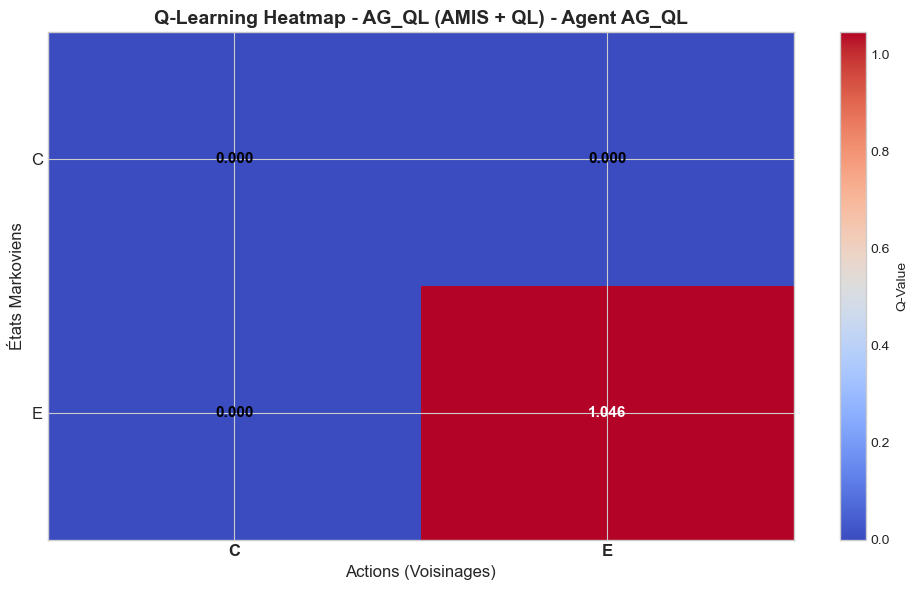

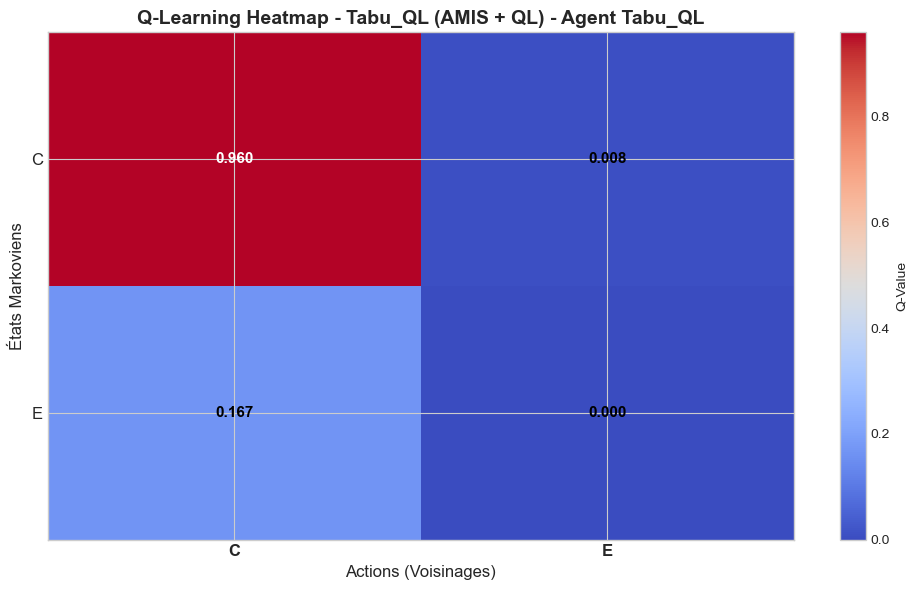


  Agents Mode ENNEMIS (Compétition + Q-Learning):


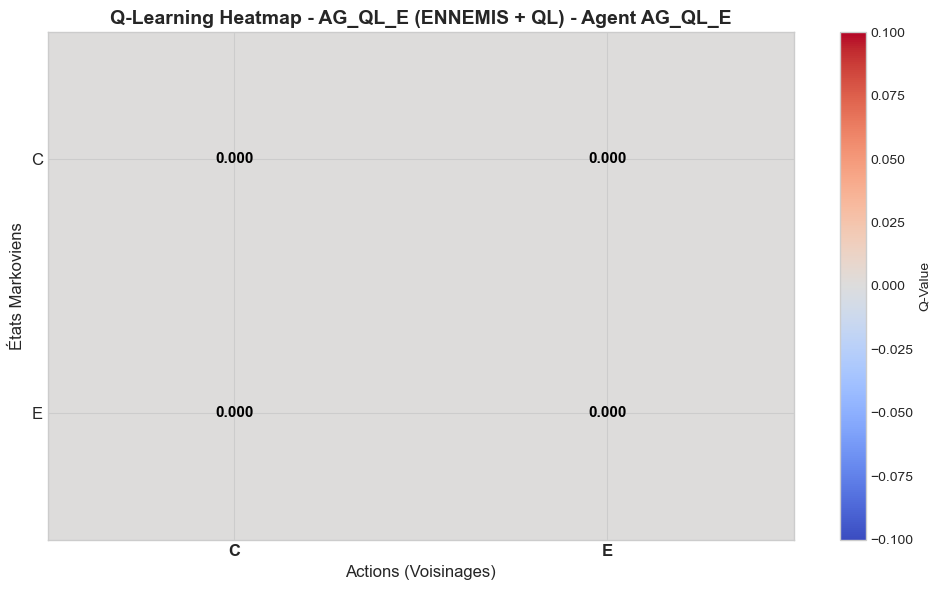

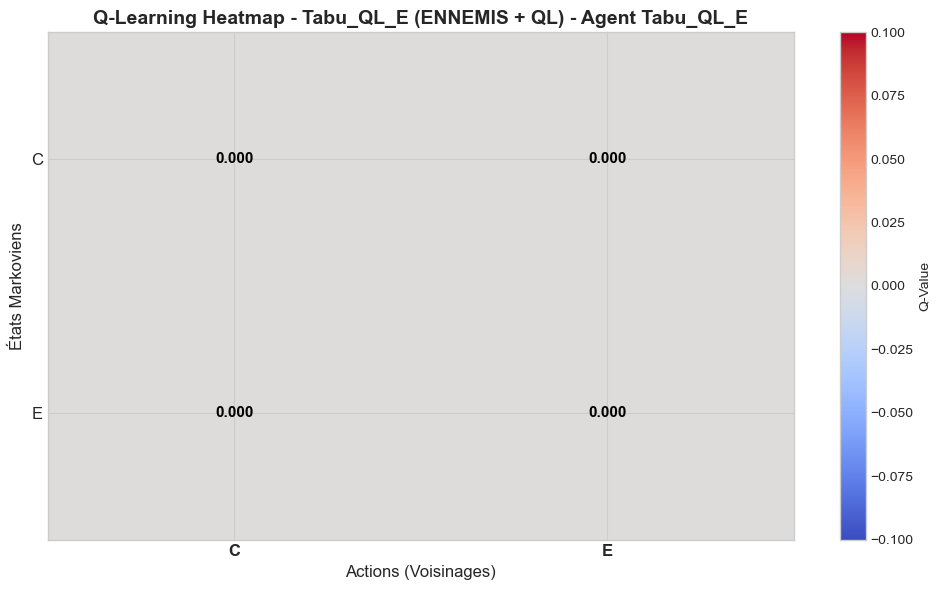


> Matrices de Diversité pour Systèmes Q-Learning

  Matrice AMIS (Mode Collaboratif):


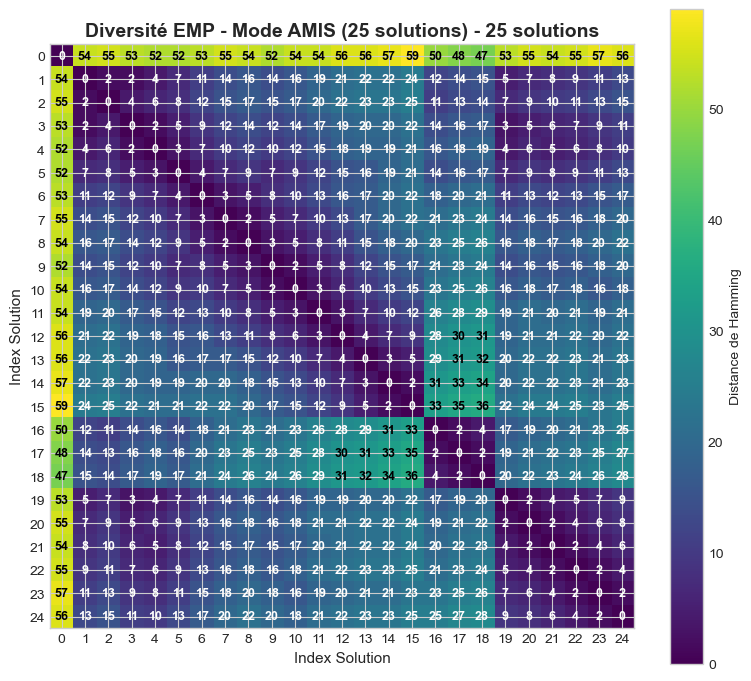


  Matrice ENNEMIS (Mode Compétitif):


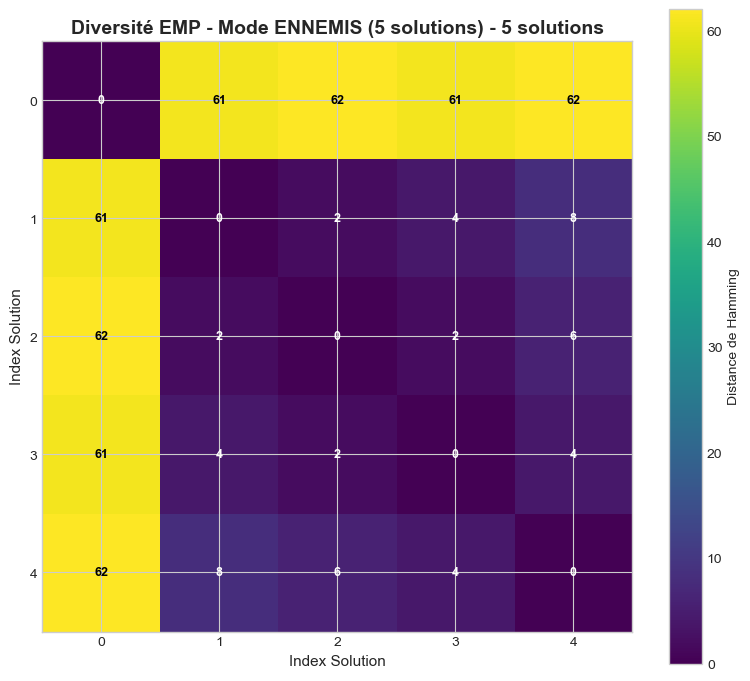


DÉMONSTRATION Q-LEARNING TERMINÉE


In [7]:
# ==========================================
# 7. BONUS : Démonstration Q-Learning avec Agents Dédiés
# ==========================================

print("\n" + "="*80)
print("DÉMONSTRATION Q-LEARNING AVEC AGENTS SPÉCIFIÉS EN Q-LEARNING")
print("="*80)

# Créer un petit système dédié pour bien montrer le Q-Learning
demo_env_ql = create_default_environment()

print("\nCréation de 2 systèmes multi-agents avec Q-Learning explicite...")

# Système AMIS avec Q-Learning
mas_ql_amis = MultiAgentSystem(demo_env_ql, mode=CollaborationMode.FRIENDS, use_qlearning=True)
mas_ql_amis.add_agent('genetic', 'AG_QL', population_size=10)
mas_ql_amis.add_agent('tabu', 'Tabu_QL', tabu_tenure=5)

# Système ENNEMIS avec Q-Learning  
mas_ql_ennemis = MultiAgentSystem(demo_env_ql, mode=CollaborationMode.ENEMIES, use_qlearning=True)
mas_ql_ennemis.add_agent('genetic', 'AG_QL_E', population_size=10)
mas_ql_ennemis.add_agent('tabu', 'Tabu_QL_E', tabu_tenure=5)

print("Lancement des optimisations (30 itérations)...")
best_ql_amis = mas_ql_amis.run(n_iterations=30, verbose=False)
best_ql_ennemis = mas_ql_ennemis.run(n_iterations=30, verbose=False)

print(f"✓ Optimisation terminée!")
print(f"  Mode AMIS:    fitness = {best_ql_amis.fitness}")
print(f"  Mode ENNEMIS: fitness = {best_ql_ennemis.fitness}")

# Affichage des Q-Tables
print("\n> Visualisation des Q-Tables pour agents avec Q-Learning")

print("\n  Agents Mode AMIS (Collaboration + Q-Learning):")
for agent_id, agent in mas_ql_amis.agents.items():
    try:
        plot_q_table_heatmap(agent, title=f"Q-Learning Heatmap - {agent_id} (AMIS + QL)")
    except Exception as e:
        print(f"    Erreur visualisation {agent_id}: {e}")

print("\n  Agents Mode ENNEMIS (Compétition + Q-Learning):")
for agent_id, agent in mas_ql_ennemis.agents.items():
    try:
        plot_q_table_heatmap(agent, title=f"Q-Learning Heatmap - {agent_id} (ENNEMIS + QL)")
    except Exception as e:
        print(f"    Erreur visualisation {agent_id}: {e}")

# Matrices de diversité pour les nouveaux systèmes
print("\n> Matrices de Diversité pour Systèmes Q-Learning")

print("\n  Matrice AMIS (Mode Collaboratif):")
if hasattr(mas_ql_amis, 'shared_memory') and mas_ql_amis.shared_memory.solutions:
    plot_distance_matrix(mas_ql_amis.shared_memory, 
                        title=f"Diversité EMP - Mode AMIS ({len(mas_ql_amis.shared_memory.solutions)} solutions)")

print("\n  Matrice ENNEMIS (Mode Compétitif):")
if hasattr(mas_ql_ennemis, 'shared_memory') and mas_ql_ennemis.shared_memory.solutions:
    plot_distance_matrix(mas_ql_ennemis.shared_memory,
                        title=f"Diversité EMP - Mode ENNEMIS ({len(mas_ql_ennemis.shared_memory.solutions)} solutions)")

print("\n" + "="*80)
print("DÉMONSTRATION Q-LEARNING TERMINÉE")
print("="*80)


In [ ]:
# ==========================================
# 8. SIMULATION COMPLÈTE : Tous les Scénarios
# ==========================================

print("\n" + "="*100)
print("SIMULATION COMPLÈTE : COMPARAISON DE TOUS LES SCÉNARIOS")
print("="*100)

def run_scenario(scenario_name, algorithm_configs, mode, use_qlearning, iterations=30, verbose=False):
    """
    Exécute un scénario avec les configurations spécifiées.
    
    Args:
        scenario_name: Nom du scénario pour l'affichage
        algorithm_configs: Liste de tuples (type, name, params)
        mode: CollaborationMode.FRIENDS ou CollaborationMode.ENEMIES
        use_qlearning: Boolean pour activer Q-Learning
        iterations: Nombre d'itérations
        verbose: Afficher les détails
        
    Returns:
        fitness_best: Meilleur fitness trouvé
        execution_time: Temps d'exécution en secondes
    """
    start_time = time.time()
    
    sys = MultiAgentSystem(env, mode=mode, use_qlearning=use_qlearning)
    for type_ag, name_ag, params in algorithm_configs:
        sys.add_agent(type_ag, name_ag, **params)
    
    best = sys.run(n_iterations=iterations, verbose=verbose)
    execution_time = time.time() - start_time
    
    fitness_best = best.fitness if best else float('inf')
    
    return fitness_best, execution_time, sys

# Définition des configurations d'algorithmes
AG_config = ('genetic', 'AG', {'population_size': 15})
TABU_config = ('tabu', 'Tabu', {'tabu_tenure': 10})
RS_config = ('sa', 'RS', {'initial_temp': 100})

# ==========================================
# ÉTAPE 1 : Algorithmes individuels sans Q-Learning
# ==========================================
print("\n" + "-"*100)
print("ÉTAPE 1 : ALGORITHMES INDIVIDUELS (SANS Q-LEARNING, SANS COLLABORATION)")
print("-"*100)

scenarios_solo = {
    'AG Solo': [AG_config],
    'Tabou Solo': [TABU_config],
    'RS Solo': [RS_config]
}

results_solo = {}
print(f"\n{'Scénario':<20} | {'Fitness':<15} | {'Temps (s)':<12} | {'Type':<15}")
print("-" * 70)

for scenario_name, configs in scenarios_solo.items():
    fitness, exec_time, _ = run_scenario(scenario_name, configs, CollaborationMode.ENEMIES, False, iterations=30)
    results_solo[scenario_name] = fitness
    print(f"{scenario_name:<20} | {fitness:<15.2f} | {exec_time:<12.3f} | Individual")

# ==========================================
# ÉTAPE 2 : Paires d'algorithmes - Mode AMIS (SANS Q-Learning)
# ==========================================
print("\n" + "-"*100)
print("ÉTAPE 2 : PAIRES D'ALGORITHMES - MODE AMIS (COLLABORATION SANS Q-LEARNING)")
print("-"*100)

scenarios_pairs_amis = {
    'AG + Tabou (Amis)': [AG_config, TABU_config],
    'AG + RS (Amis)': [AG_config, RS_config],
    'Tabou + RS (Amis)': [TABU_config, RS_config],
    'AG + Tabou + RS (Amis)': [AG_config, TABU_config, RS_config]
}

results_pairs_amis = {}
print(f"\n{'Scénario':<30} | {'Fitness':<15} | {'Temps (s)':<12} | {'Mode':<15}")
print("-" * 80)

for scenario_name, configs in scenarios_pairs_amis.items():
    fitness, exec_time, _ = run_scenario(scenario_name, configs, CollaborationMode.FRIENDS, False, iterations=30)
    results_pairs_amis[scenario_name] = fitness
    print(f"{scenario_name:<30} | {fitness:<15.2f} | {exec_time:<12.3f} | AMIS")

# ==========================================
# ÉTAPE 3 : Paires d'algorithmes - Mode ENNEMIS (SANS Q-Learning)
# ==========================================
print("\n" + "-"*100)
print("ÉTAPE 3 : PAIRES D'ALGORITHMES - MODE ENNEMIS (COMPÉTITION SANS Q-LEARNING)")
print("-"*100)

scenarios_pairs_ennemis = {
    'AG + Tabou (Ennemis)': [AG_config, TABU_config],
    'AG + RS (Ennemis)': [AG_config, RS_config],
    'Tabou + RS (Ennemis)': [TABU_config, RS_config],
    'AG + Tabou + RS (Ennemis)': [AG_config, TABU_config, RS_config]
}

results_pairs_ennemis = {}
print(f"\n{'Scénario':<30} | {'Fitness':<15} | {'Temps (s)':<12} | {'Mode':<15}")
print("-" * 80)

for scenario_name, configs in scenarios_pairs_ennemis.items():
    fitness, exec_time, _ = run_scenario(scenario_name, configs, CollaborationMode.ENEMIES, False, iterations=30)
    results_pairs_ennemis[scenario_name] = fitness
    print(f"{scenario_name:<30} | {fitness:<15.2f} | {exec_time:<12.3f} | ENNEMIS")

# ==========================================
# ÉTAPE 4 : Paires d'algorithmes - Mode AMIS (AVEC Q-Learning)
# ==========================================
print("\n" + "-"*100)
print("ÉTAPE 4 : PAIRES D'ALGORITHMES - MODE AMIS (COLLABORATION AVEC Q-LEARNING)")
print("-"*100)

scenarios_ql_amis = {
    'AG + Tabou (Amis + QL)': [AG_config, TABU_config],
    'AG + RS (Amis + QL)': [AG_config, RS_config],
    'Tabou + RS (Amis + QL)': [TABU_config, RS_config],
    'AG + Tabou + RS (Amis + QL)': [AG_config, TABU_config, RS_config]
}
scenarios_ql_ennemis = {
    'AG + Tabou (Ennemis + QL)': [AG_config, TABU_config],
    'AG + RS (Ennemis + QL)': [AG_config, RS_config],
    'Tabou + RS (Ennemis + QL)': [TABU_config, RS_config],
    'AG + Tabou + RS (Ennemis + QL)': [AG_config, TABU_config, RS_config]
}
results_ql_amis = {}
print(f"\n{'Scénario':<30} | {'Fitness':<15} | {'Temps (s)':<12} | {'Mode + Q-Learning':<20}")
print("-" * 90)

for scenario_name, configs in scenarios_ql_amis.items():
    fitness, exec_time, sys_ql = run_scenario(scenario_name, configs, CollaborationMode.FRIENDS, True, iterations=30)
    results_ql_amis[scenario_name] = fitness
    print(f"{scenario_name:<30} | {fitness:<15.2f} | {exec_time:<12.3f} | AMIS + QL")

# ==========================================
# ÉTAPE 5 : Paires d'algorithmes - Mode ENNEMIS (AVEC Q-Learning)
# ==========================================
print("\n" + "-"*100)
print("ÉTAPE 5 : PAIRES D'ALGORITHMES - MODE ENNEMIS (COMPÉTITION AVEC Q-LEARNING)")
print("-"*100)

scenarios_ql_ennemis = {
    'AG + Tabou (Ennemis + QL)': [AG_config, TABU_config],
    'AG + RS (Ennemis + QL)': [AG_config, RS_config],
    'Tabou + RS (Ennemis + QL)': [TABU_config, RS_config],
    'AG + Tabou + RS (Ennemis + QL)': [AG_config, TABU_config, RS_config]
}

results_ql_ennemis = {}
print(f"\n{'Scénario':<30} | {'Fitness':<15} | {'Temps (s)':<12} | {'Mode + Q-Learning':<20}")
print("-" * 90)

for scenario_name, configs in scenarios_ql_ennemis.items():
    fitness, exec_time, sys_ql = run_scenario(scenario_name, configs, CollaborationMode.ENEMIES, True, iterations=30)
    results_ql_ennemis[scenario_name] = fitness
    print(f"{scenario_name:<30} | {fitness:<15.2f} | {exec_time:<12.3f} | ENNEMIS + QL")

# ==========================================
# RÉSUMÉ COMPARATIF COMPLET
# ==========================================
print("\n" + "="*100)
print("RÉSUMÉ COMPARATIF GLOBAL")
print("="*100)

# Organiser tous les résultats
all_results = {
    'Solo (Sans Collab, Sans QL)': results_solo,
    'Paires Amis (Collaboration, Sans QL)': results_pairs_amis,
    'Paires Ennemis (Compétition, Sans QL)': results_pairs_ennemis,
    'Paires Amis + Q-Learning': results_ql_amis,
    'Paires Ennemis + Q-Learning': results_ql_ennemis
}

baseline_solo = min(results_solo.values())

for category, results in all_results.items():
    print(f"\n{category}:")
    print(f"{'  Scénario':<40} | {'Fitness':<15} | {'Amélioration vs Baseline':<25}")
    print("-" * 85)
    for scenario, fitness in sorted(results.items(), key=lambda x: x[1]):
        improvement = ((baseline_solo - fitness) / baseline_solo) * 100
        improvement_str = f"{improvement:+.2f}%" if improvement != 0 else "Reference"
        print(f"  {scenario:<40} | {fitness:<15.2f} | {improvement_str:<25}")

# ==========================================
# CLASSEMENT FINAL
# ==========================================
print("\n" + "="*100)
print("TOP 10 : MEILLEURS SCÉNARIOS")
print("="*100)

# Combiner tous les résultats
all_combined = {}
for category, results in all_results.items():
    for scenario, fitness in results.items():
        all_combined[f"{scenario} [{category}]"] = fitness

# Trier par fitness
ranked = sorted(all_combined.items(), key=lambda x: x[1])

print(f"\n{'Rang':<6} | {'Scénario':<65} | {'Fitness':<12} | {'Amélioration':<15}")
print("-" * 105)

for rank, (scenario, fitness) in enumerate(ranked[:10], 1):
    improvement = ((baseline_solo - fitness) / baseline_solo) * 100
    improvement_str = f"{improvement:+.2f}%"
    print(f"{rank:<6} | {scenario:<65} | {fitness:<12.2f} | {improvement_str:<15}")

print("\n" + "="*100)
print("SIMULATION COMPLÈTE TERMINÉE")
print("="*100)



SIMULATION COMPLÈTE : COMPARAISON DE TOUS LES SCÉNARIOS

----------------------------------------------------------------------------------------------------
ÉTAPE 1 : ALGORITHMES INDIVIDUELS (SANS Q-LEARNING, SANS COLLABORATION)
----------------------------------------------------------------------------------------------------

Scénario             | Fitness         | Temps (s)    | Type           
----------------------------------------------------------------------
AG Solo              | 35.00           | 1.030        | Individual
Tabou Solo           | 35.00           | 0.644        | Individual
RS Solo              | 35.00           | 0.056        | Individual

----------------------------------------------------------------------------------------------------
ÉTAPE 2 : PAIRES D'ALGORITHMES - MODE AMIS (COLLABORATION SANS Q-LEARNING)
----------------------------------------------------------------------------------------------------

Scénario                       | Fitness    


COMPARAISON COMPLÈTE : TOUS LES ALGORITHMES (AG + TABU + RS)
Allies vs Ennemis - Sans/Avec Q-Learning

------------------------------------------------------------------------------------------------------------------------
SCÉNARIO 1 : TRIO (AG + TABU + RS) - MODE AMIS (COLLABORATION) - SANS Q-LEARNING
------------------------------------------------------------------------------------------------------------------------

Lancement de l'optimisation (50 itérations)...
✓ Optimisation terminée!
  Meilleur fitness : 35.00
  Temps d'exécution : 3.158s
  Nombre d'agents : 3
  Solutions en mémoire : 25

  Historiques de convergence par agent:
    - AG: Initial=36.00, Final=35.00, Amélioration=1.00
    - Tabu: Initial=36.00, Final=35.00, Amélioration=1.00
    - RS: Initial=37.00, Final=37.00, Amélioration=0.00

------------------------------------------------------------------------------------------------------------------------
SCÉNARIO 2 : TRIO (AG + TABU + RS) - MODE ENNEMIS (COMPÉTITIO

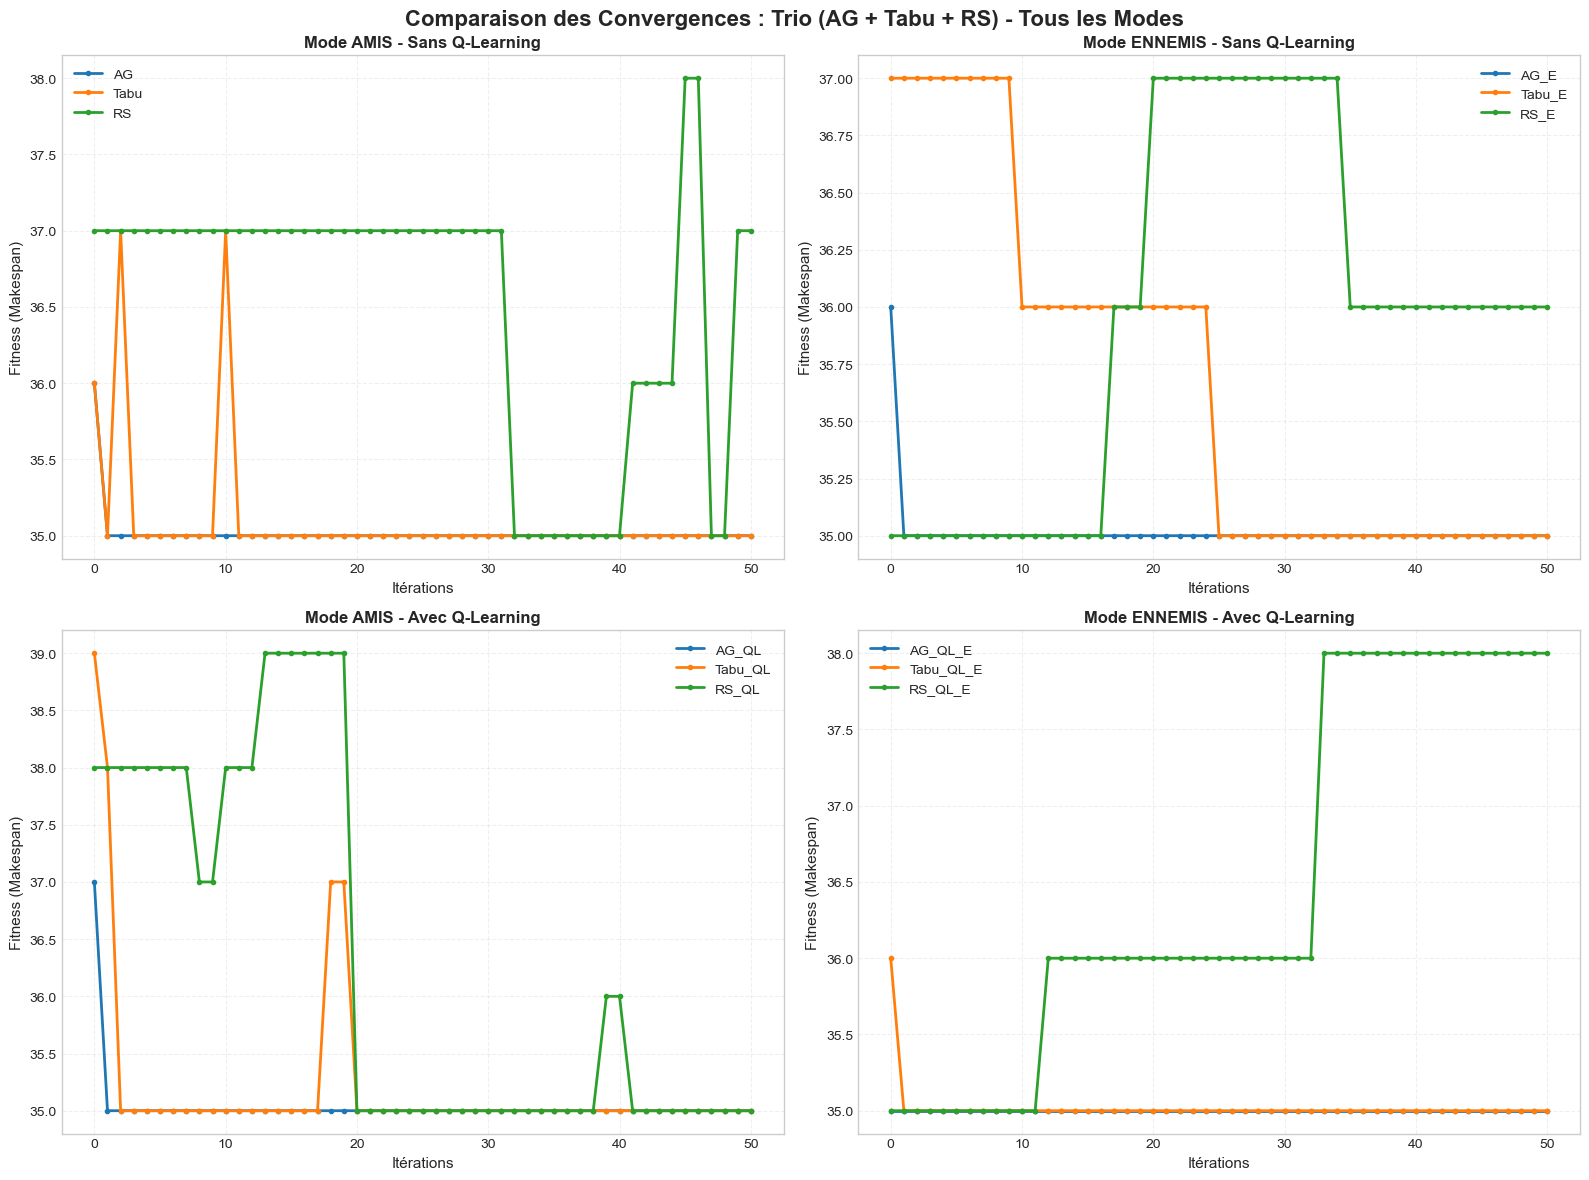


> Visualisation 2 : Matrices de Diversité (EMP) pour tous les scénarios


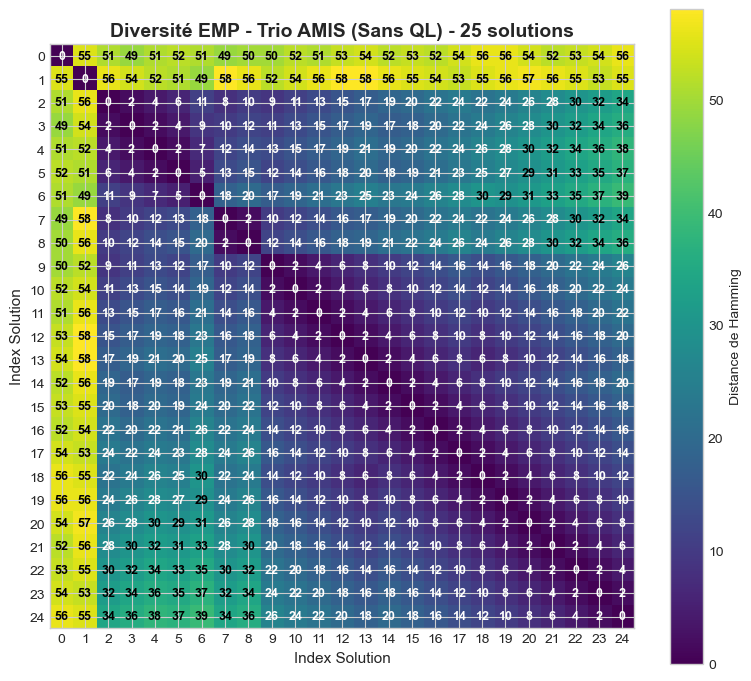

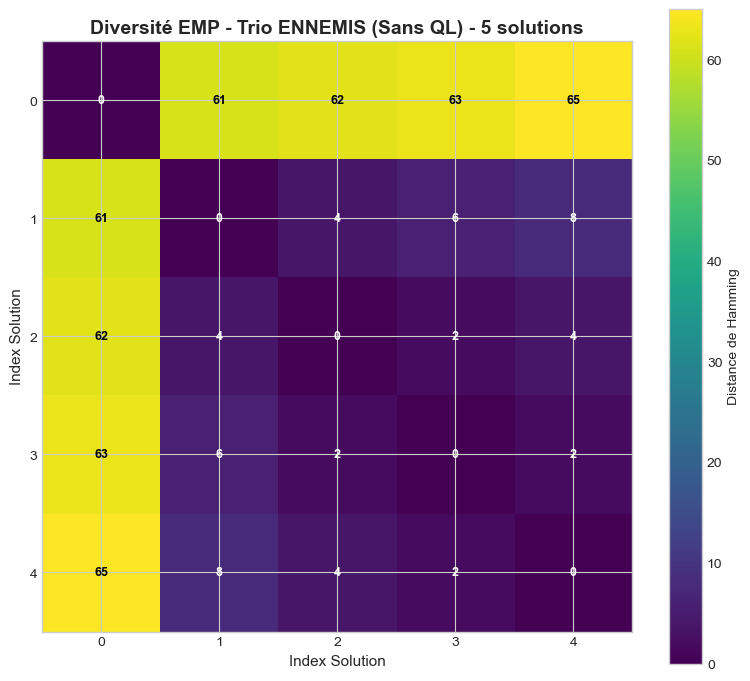

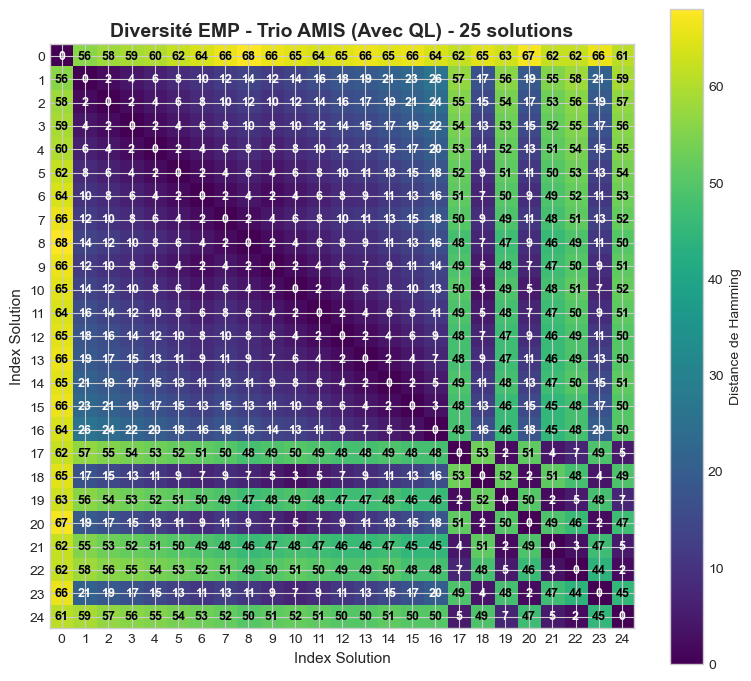

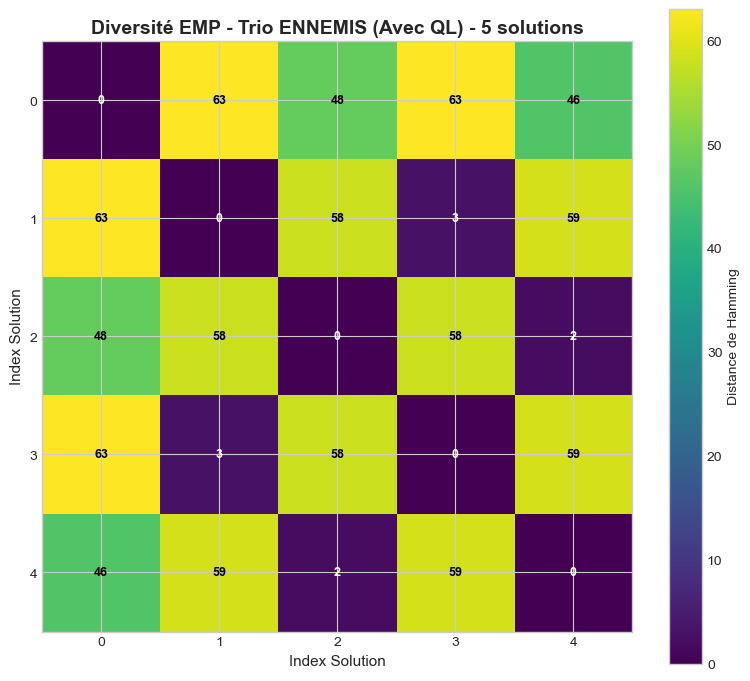


> Visualisation 3 : Q-Tables (Apprentissage Markovien)

  Q-Tables - Mode AMIS Avec Q-Learning:


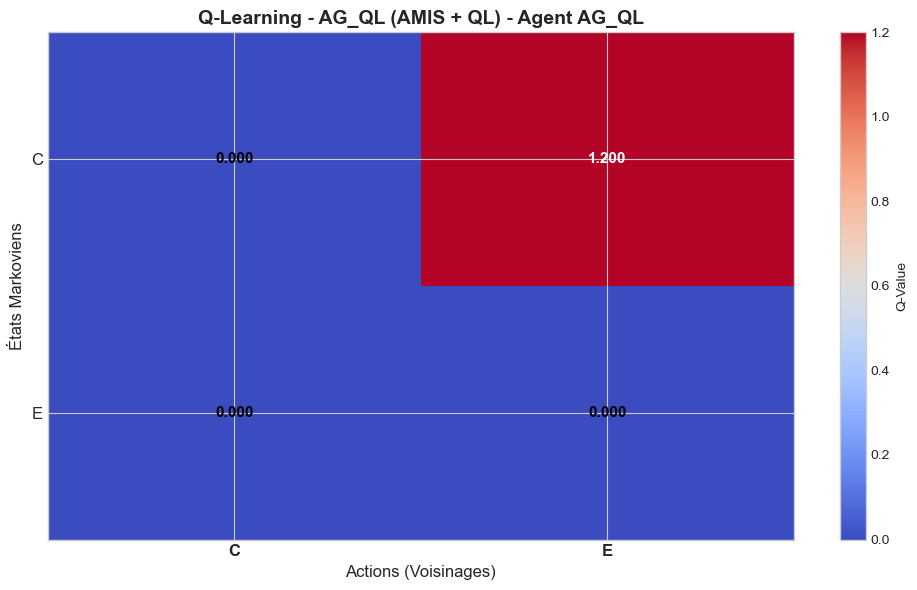

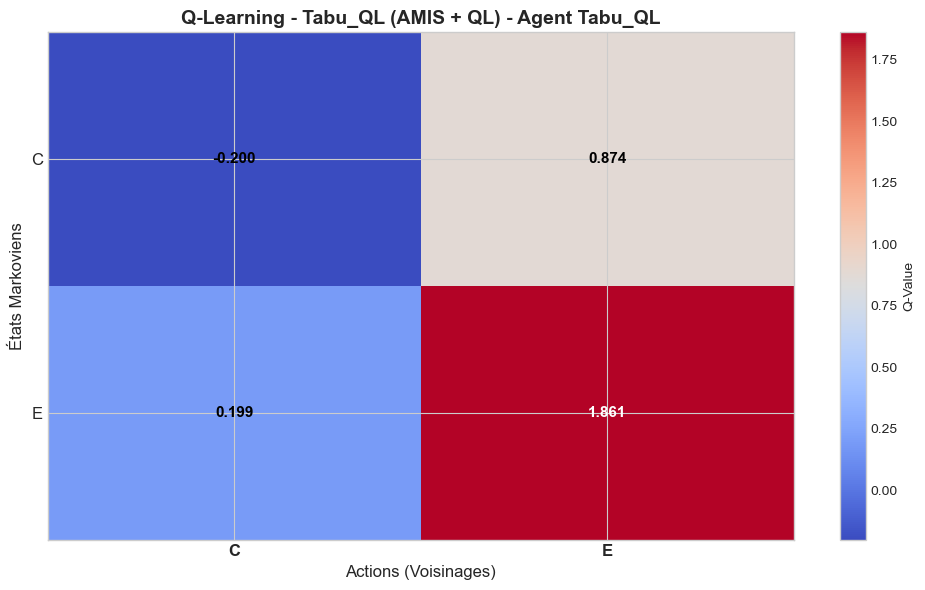

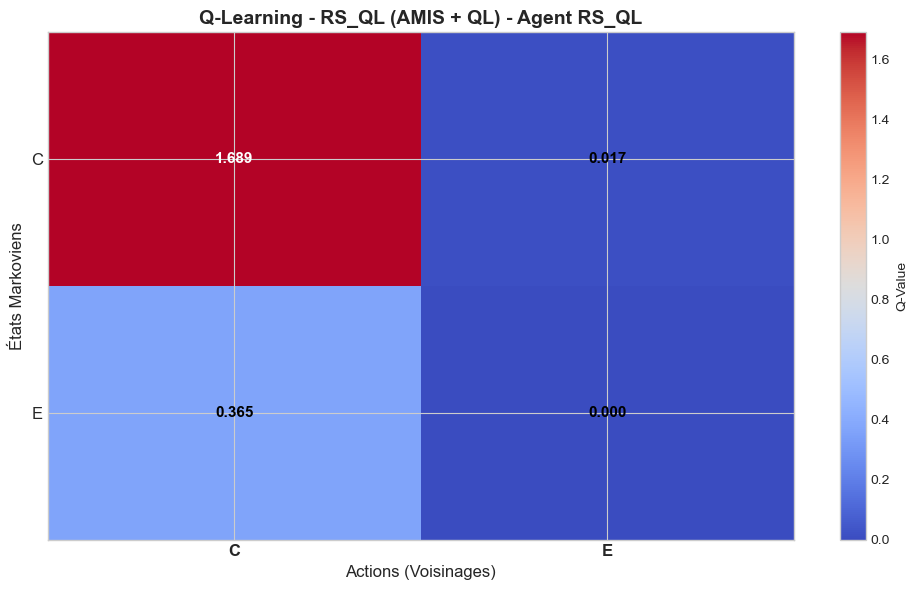


  Q-Tables - Mode ENNEMIS Avec Q-Learning:


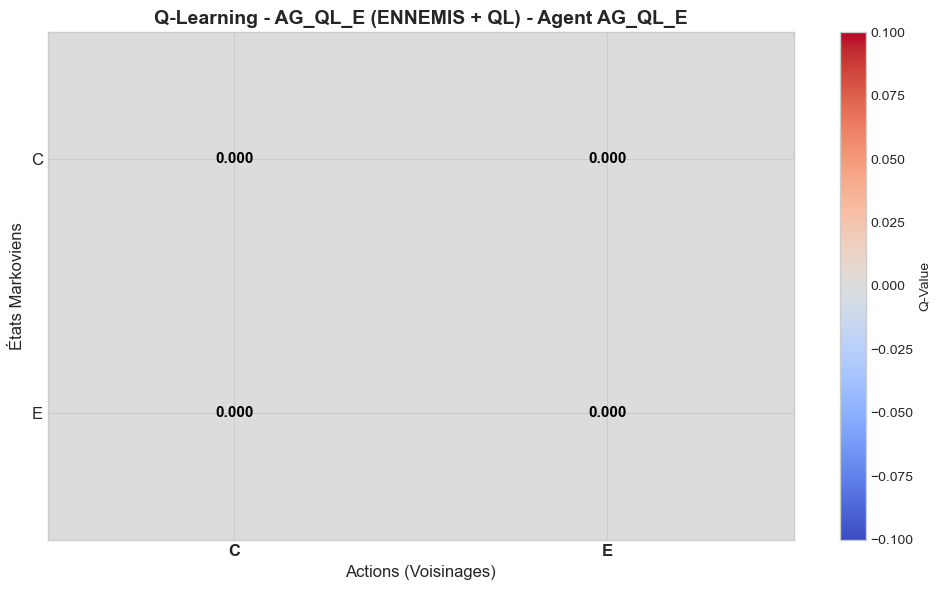

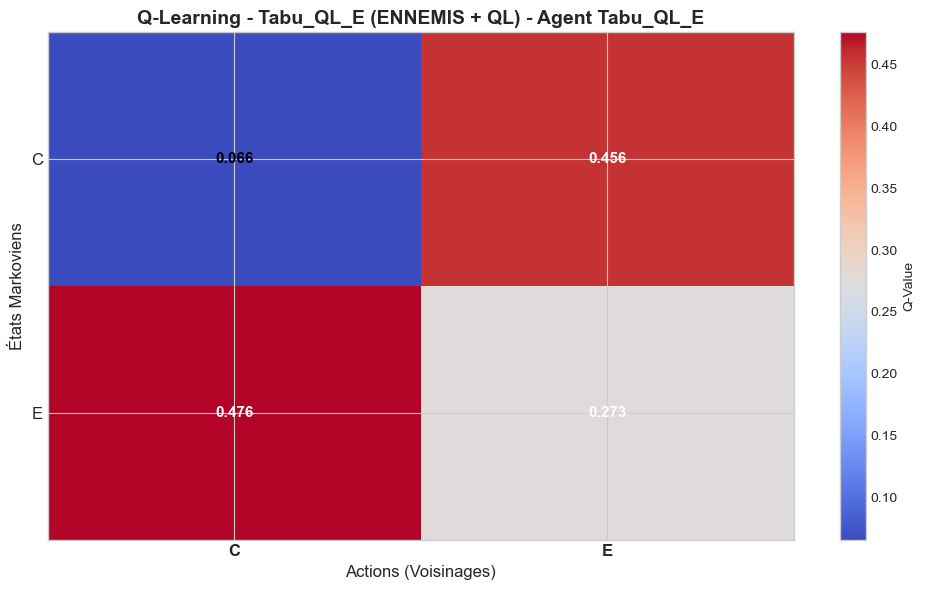

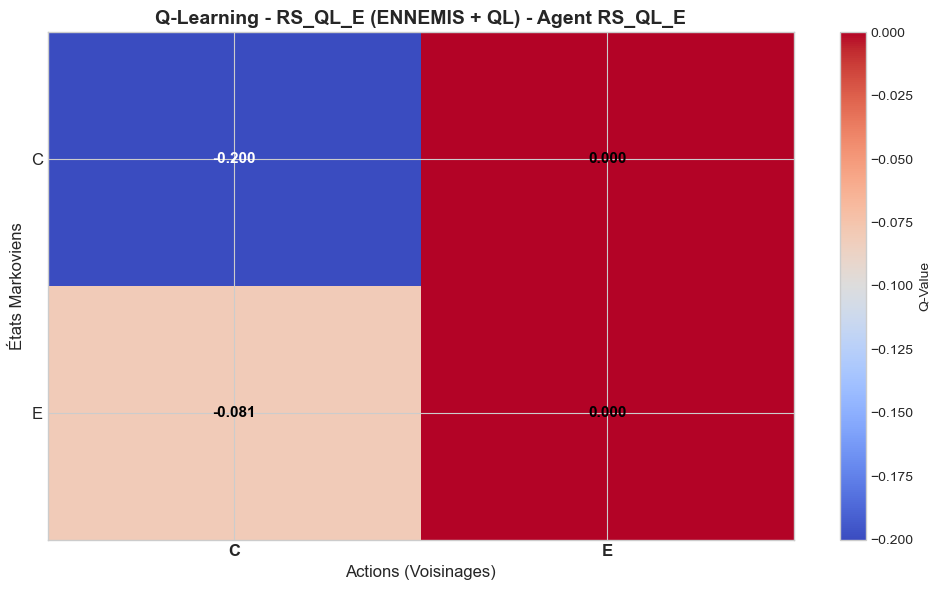


ANALYSE DÉTAILLÉE : IMPACT DE Q-LEARNING ET DU MODE DE COLLABORATION

Sans Q-Learning (Baseline Collaborative Methods):
  Amélioration AMIS vs ENNEMIS : +0.00%
    - AMIS fitness   : 35.00
    - ENNEMIS fitness: 35.00

Avec Q-Learning (Reinforcement Learning):
  Amélioration AMIS vs ENNEMIS : +0.00%
    - AMIS fitness   : 35.00
    - ENNEMIS fitness: 35.00

Impact du Q-Learning :
  Mode AMIS    : +0.00% (Sans QL: 35.00 → Avec QL: 35.00)
  Mode ENNEMIS : +0.00% (Sans QL: 35.00 → Avec QL: 35.00)

Meilleur Scénario Global:
  Meilleur : Trio AMIS (Sans QL) (fitness=35.00)
  Pire    : Trio AMIS (Sans QL) (fitness=35.00)
  Amélioration globale : 0.00%

ANALYSE COMPLÈTE TERMINÉE


In [9]:
# ==========================================
# 9. COMPARAISON COMPLÈTE : Tous les Algorithmes (AG + Tabu + RS)
#    Allies vs Ennemis, Sans/Avec Q-Learning
# ==========================================

print("\n" + "="*120)
print("COMPARAISON COMPLÈTE : TOUS LES ALGORITHMES (AG + TABU + RS)")
print("Allies vs Ennemis - Sans/Avec Q-Learning")
print("="*120)

# Configuration de base : 3 algorithmes
trio_full = [
    ('genetic', 'AG', {'population_size': 15}),
    ('tabu', 'Tabu', {'tabu_tenure': 10}),
    ('sa', 'RS', {'initial_temp': 100})
]

# ==========================================
# SCÉNARIO 1 : Trio - Mode AMIS - SANS Q-Learning
# ==========================================
print("\n" + "-"*120)
print("SCÉNARIO 1 : TRIO (AG + TABU + RS) - MODE AMIS (COLLABORATION) - SANS Q-LEARNING")
print("-"*120)

print("\nLancement de l'optimisation (50 itérations)...")
start_time = time.time()
mas_trio_amis_noql = MultiAgentSystem(env, mode=CollaborationMode.FRIENDS, use_qlearning=False)
for type_ag, name_ag, params in trio_full:
    mas_trio_amis_noql.add_agent(type_ag, name_ag, **params)

best_trio_amis_noql = mas_trio_amis_noql.run(n_iterations=50, verbose=False)
time_trio_amis_noql = time.time() - start_time

print(f"✓ Optimisation terminée!")
print(f"  Meilleur fitness : {best_trio_amis_noql.fitness:.2f}")
print(f"  Temps d'exécution : {time_trio_amis_noql:.3f}s")
print(f"  Nombre d'agents : {len(mas_trio_amis_noql.agents)}")
print(f"  Solutions en mémoire : {len(mas_trio_amis_noql.shared_memory.solutions)}")

# Affichage des convergences
print(f"\n  Historiques de convergence par agent:")
for agent_id, agent in mas_trio_amis_noql.agents.items():
    if hasattr(agent, 'fitness_history') and agent.fitness_history:
        print(f"    - {agent_id}: Initial={agent.fitness_history[0]:.2f}, Final={agent.fitness_history[-1]:.2f}, Amélioration={agent.fitness_history[0] - agent.fitness_history[-1]:.2f}")

# ==========================================
# SCÉNARIO 2 : Trio - Mode ENNEMIS - SANS Q-Learning
# ==========================================
print("\n" + "-"*120)
print("SCÉNARIO 2 : TRIO (AG + TABU + RS) - MODE ENNEMIS (COMPÉTITION) - SANS Q-LEARNING")
print("-"*120)

print("\nLancement de l'optimisation (50 itérations)...")
start_time = time.time()
mas_trio_ennemis_noql = MultiAgentSystem(env, mode=CollaborationMode.ENEMIES, use_qlearning=False)
for type_ag, name_ag, params in trio_full:
    mas_trio_ennemis_noql.add_agent(type_ag, name_ag + "_E", **params)

best_trio_ennemis_noql = mas_trio_ennemis_noql.run(n_iterations=50, verbose=False)
time_trio_ennemis_noql = time.time() - start_time

print(f"✓ Optimisation terminée!")
print(f"  Meilleur fitness : {best_trio_ennemis_noql.fitness:.2f}")
print(f"  Temps d'exécution : {time_trio_ennemis_noql:.3f}s")
print(f"  Nombre d'agents : {len(mas_trio_ennemis_noql.agents)}")
print(f"  Solutions en mémoire : {len(mas_trio_ennemis_noql.shared_memory.solutions)}")

# Affichage des convergences
print(f"\n  Historiques de convergence par agent:")
for agent_id, agent in mas_trio_ennemis_noql.agents.items():
    if hasattr(agent, 'fitness_history') and agent.fitness_history:
        print(f"    - {agent_id}: Initial={agent.fitness_history[0]:.2f}, Final={agent.fitness_history[-1]:.2f}, Amélioration={agent.fitness_history[0] - agent.fitness_history[-1]:.2f}")

# ==========================================
# SCÉNARIO 3 : Trio - Mode AMIS - AVEC Q-Learning
# ==========================================
print("\n" + "-"*120)
print("SCÉNARIO 3 : TRIO (AG + TABU + RS) - MODE AMIS (COLLABORATION) - AVEC Q-LEARNING")
print("-"*120)

print("\nLancement de l'optimisation (50 itérations)...")
start_time = time.time()
mas_trio_amis_ql = MultiAgentSystem(env, mode=CollaborationMode.FRIENDS, use_qlearning=True)
for type_ag, name_ag, params in trio_full:
    mas_trio_amis_ql.add_agent(type_ag, name_ag + "_QL", **params)

best_trio_amis_ql = mas_trio_amis_ql.run(n_iterations=50, verbose=False)
time_trio_amis_ql = time.time() - start_time

print(f"✓ Optimisation terminée!")
print(f"  Meilleur fitness : {best_trio_amis_ql.fitness:.2f}")
print(f"  Temps d'exécution : {time_trio_amis_ql:.3f}s")
print(f"  Nombre d'agents : {len(mas_trio_amis_ql.agents)}")
print(f"  Solutions en mémoire : {len(mas_trio_amis_ql.shared_memory.solutions)}")

# Affichage des convergences
print(f"\n  Historiques de convergence par agent:")
for agent_id, agent in mas_trio_amis_ql.agents.items():
    if hasattr(agent, 'fitness_history') and agent.fitness_history:
        print(f"    - {agent_id}: Initial={agent.fitness_history[0]:.2f}, Final={agent.fitness_history[-1]:.2f}, Amélioration={agent.fitness_history[0] - agent.fitness_history[-1]:.2f}")

# ==========================================
# SCÉNARIO 4 : Trio - Mode ENNEMIS - AVEC Q-Learning
# ==========================================
print("\n" + "-"*120)
print("SCÉNARIO 4 : TRIO (AG + TABU + RS) - MODE ENNEMIS (COMPÉTITION) - AVEC Q-LEARNING")
print("-"*120)

print("\nLancement de l'optimisation (50 itérations)...")
start_time = time.time()
mas_trio_ennemis_ql = MultiAgentSystem(env, mode=CollaborationMode.ENEMIES, use_qlearning=True)
for type_ag, name_ag, params in trio_full:
    mas_trio_ennemis_ql.add_agent(type_ag, name_ag + "_QL_E", **params)

best_trio_ennemis_ql = mas_trio_ennemis_ql.run(n_iterations=50, verbose=False)
time_trio_ennemis_ql = time.time() - start_time

print(f"✓ Optimisation terminée!")
print(f"  Meilleur fitness : {best_trio_ennemis_ql.fitness:.2f}")
print(f"  Temps d'exécution : {time_trio_ennemis_ql:.3f}s")
print(f"  Nombre d'agents : {len(mas_trio_ennemis_ql.agents)}")
print(f"  Solutions en mémoire : {len(mas_trio_ennemis_ql.shared_memory.solutions)}")

# Affichage des convergences
print(f"\n  Historiques de convergence par agent:")
for agent_id, agent in mas_trio_ennemis_ql.agents.items():
    if hasattr(agent, 'fitness_history') and agent.fitness_history:
        print(f"    - {agent_id}: Initial={agent.fitness_history[0]:.2f}, Final={agent.fitness_history[-1]:.2f}, Amélioration={agent.fitness_history[0] - agent.fitness_history[-1]:.2f}")

# ==========================================
# TABLEAU COMPARATIF : TOUS LES SCÉNARIOS
# ==========================================
print("\n" + "="*120)
print("TABLEAU COMPARATIF : TOUS LES SCÉNARIOS COMPLETS")
print("="*120)

scenarios_complete = {
    'Trio AMIS (Sans QL)': (best_trio_amis_noql.fitness, time_trio_amis_noql, mas_trio_amis_noql),
    'Trio ENNEMIS (Sans QL)': (best_trio_ennemis_noql.fitness, time_trio_ennemis_noql, mas_trio_ennemis_noql),
    'Trio AMIS (Avec QL)': (best_trio_amis_ql.fitness, time_trio_amis_ql, mas_trio_amis_ql),
    'Trio ENNEMIS (Avec QL)': (best_trio_ennemis_ql.fitness, time_trio_ennemis_ql, mas_trio_ennemis_ql)
}

print(f"\n{'Scénario':<30} | {'Fitness':<12} | {'Temps (s)':<12} | {'# Solutions':<14} | {'Insertion %':<12}")
print("-" * 95)

baseline_fitness = min(v[0] for v in scenarios_complete.values())
for scenario, (fitness, exec_time, sys) in scenarios_complete.items():
    insertions = sys.shared_memory.insertions if hasattr(sys.shared_memory, 'insertions') else 0
    solutions_count = len(sys.shared_memory.solutions) if hasattr(sys, 'shared_memory') else 0
    insertion_rate = (insertions / (insertions + sys.shared_memory.rejections_duplicate) * 100) if (insertions + sys.shared_memory.rejections_duplicate) > 0 else 0
    
    print(f"{scenario:<30} | {fitness:<12.2f} | {exec_time:<12.3f} | {solutions_count:<14} | {insertion_rate:<12.1f}%")

# ==========================================
# VISUALISATIONS COMPARATIVES
# ==========================================
print("\n" + "="*120)
print("VISUALISATIONS COMPARATIVES")
print("="*120)

# 1. Comparaison des courbes de convergence
print("\n> Visualisation 1 : Courbes de Convergence Comparatives")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Comparaison des Convergences : Trio (AG + Tabu + RS) - Tous les Modes", fontsize=16, fontweight='bold')

scenarios_viz = [
    (mas_trio_amis_noql, "Mode AMIS - Sans Q-Learning", axes[0, 0]),
    (mas_trio_ennemis_noql, "Mode ENNEMIS - Sans Q-Learning", axes[0, 1]),
    (mas_trio_amis_ql, "Mode AMIS - Avec Q-Learning", axes[1, 0]),
    (mas_trio_ennemis_ql, "Mode ENNEMIS - Avec Q-Learning", axes[1, 1])
]

for mas, title, ax in scenarios_viz:
    for agent_id, agent in mas.agents.items():
        if hasattr(agent, 'fitness_history') and agent.fitness_history:
            ax.plot(agent.fitness_history, label=agent_id, linewidth=2, marker='o', markersize=3)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Itérations", fontsize=11)
    ax.set_ylabel("Fitness (Makespan)", fontsize=11)
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# 2. Matrice de Diversité pour chaque scénario
print("\n> Visualisation 2 : Matrices de Diversité (EMP) pour tous les scénarios")

diversity_scenarios = [
    (mas_trio_amis_noql, "Diversité EMP - Trio AMIS (Sans QL)"),
    (mas_trio_ennemis_noql, "Diversité EMP - Trio ENNEMIS (Sans QL)"),
    (mas_trio_amis_ql, "Diversité EMP - Trio AMIS (Avec QL)"),
    (mas_trio_ennemis_ql, "Diversité EMP - Trio ENNEMIS (Avec QL)")
]

for mas, title in diversity_scenarios:
    try:
        if hasattr(mas, 'shared_memory') and mas.shared_memory.solutions:
            plot_distance_matrix(mas.shared_memory, title=title)
    except Exception as e:
        print(f"  Erreur affichage matrice: {e}")

# 3. Visualisation Q-Tables pour tous les agents avec Q-Learning
print("\n> Visualisation 3 : Q-Tables (Apprentissage Markovien)")

print("\n  Q-Tables - Mode AMIS Avec Q-Learning:")
for agent_id, agent in mas_trio_amis_ql.agents.items():
    try:
        plot_q_table_heatmap(agent, title=f"Q-Learning - {agent_id} (AMIS + QL)")
    except Exception as e:
        print(f"    Erreur visualisation {agent_id}: {e}")

print("\n  Q-Tables - Mode ENNEMIS Avec Q-Learning:")
for agent_id, agent in mas_trio_ennemis_ql.agents.items():
    try:
        plot_q_table_heatmap(agent, title=f"Q-Learning - {agent_id} (ENNEMIS + QL)")
    except Exception as e:
        print(f"    Erreur visualisation {agent_id}: {e}")

# ==========================================
# ANALYSE DÉTAILLÉE : Impact de Q-Learning et Mode Collaboration
# ==========================================
print("\n" + "="*120)
print("ANALYSE DÉTAILLÉE : IMPACT DE Q-LEARNING ET DU MODE DE COLLABORATION")
print("="*120)

# Comparaison Sans Q-Learning
print("\nSans Q-Learning (Baseline Collaborative Methods):")
improvement_noql = ((best_trio_ennemis_noql.fitness - best_trio_amis_noql.fitness) / best_trio_ennemis_noql.fitness) * 100
print(f"  Amélioration AMIS vs ENNEMIS : {improvement_noql:+.2f}%")
print(f"    - AMIS fitness   : {best_trio_amis_noql.fitness:.2f}")
print(f"    - ENNEMIS fitness: {best_trio_ennemis_noql.fitness:.2f}")

# Comparaison Avec Q-Learning
print("\nAvec Q-Learning (Reinforcement Learning):")
improvement_ql = ((best_trio_ennemis_ql.fitness - best_trio_amis_ql.fitness) / best_trio_ennemis_ql.fitness) * 100
print(f"  Amélioration AMIS vs ENNEMIS : {improvement_ql:+.2f}%")
print(f"    - AMIS fitness   : {best_trio_amis_ql.fitness:.2f}")
print(f"    - ENNEMIS fitness: {best_trio_ennemis_ql.fitness:.2f}")

# Impact de Q-Learning pour chaque mode
print("\nImpact du Q-Learning :")
impact_amis = ((best_trio_amis_noql.fitness - best_trio_amis_ql.fitness) / best_trio_amis_noql.fitness) * 100
impact_ennemis = ((best_trio_ennemis_noql.fitness - best_trio_ennemis_ql.fitness) / best_trio_ennemis_noql.fitness) * 100
print(f"  Mode AMIS    : {impact_amis:+.2f}% (Sans QL: {best_trio_amis_noql.fitness:.2f} → Avec QL: {best_trio_amis_ql.fitness:.2f})")
print(f"  Mode ENNEMIS : {impact_ennemis:+.2f}% (Sans QL: {best_trio_ennemis_noql.fitness:.2f} → Avec QL: {best_trio_ennemis_ql.fitness:.2f})")

# Meilleur scénario global
print("\nMeilleur Scénario Global:")
all_fitness = {
    'Trio AMIS (Sans QL)': best_trio_amis_noql.fitness,
    'Trio ENNEMIS (Sans QL)': best_trio_ennemis_noql.fitness,
    'Trio AMIS (Avec QL)': best_trio_amis_ql.fitness,
    'Trio ENNEMIS (Avec QL)': best_trio_ennemis_ql.fitness
}
best_scenario = min(all_fitness, key=all_fitness.get)
worst_scenario = max(all_fitness, key=all_fitness.get)
global_improvement = ((all_fitness[worst_scenario] - all_fitness[best_scenario]) / all_fitness[worst_scenario]) * 100

print(f"  Meilleur : {best_scenario} (fitness={all_fitness[best_scenario]:.2f})")
print(f"  Pire    : {worst_scenario} (fitness={all_fitness[worst_scenario]:.2f})")
print(f"  Amélioration globale : {global_improvement:.2f}%")

print("\n" + "="*120)
print("ANALYSE COMPLÈTE TERMINÉE")
print("="*120)


In [ ]:
# ==========================================
# RÉSULTATS FINAUX : TABLEAU COMPARATIF COMPLET
# Scénarios avec nombre de patients aléatoire (20-150)
# 3 itérations par configuration
# ==========================================

import pandas as pd
from datetime import datetime

print("\n" + "="*150)
print("TABLEAU COMPARATIF FINAL - TOUS LES SCÉNARIOS")
print(f"Généré le: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*150)

# Configuration générale
NUM_ITERATIONS_PER_SCENARIO = 3
PATIENT_RANGE = (20, 150)
OPTIMIZATION_ITERATIONS = 50

# Configurations d'algorithmes
AG_config = ('genetic', 'AG', {'population_size': 15})
TABU_config = ('tabu', 'Tabu', {'tabu_tenure': 10})
RS_config = ('sa', 'RS', {'initial_temp': 100})

scenarios_ql_amis = {
    'AG + Tabou (Amis + QL)': [AG_config, TABU_config],
    'AG + RS (Amis + QL)': [AG_config, RS_config],
    'Tabou + RS (Amis + QL)': [TABU_config, RS_config],
    'AG + Tabou + RS (Amis + QL)': [AG_config, TABU_config, RS_config]
}
scenarios_ql_ennemis = {
    'AG + Tabou (Ennemis + QL)': [AG_config, TABU_config],
    'AG + RS (Ennemis + QL)': [AG_config, RS_config],
    'Tabou + RS (Ennemis + QL)': [TABU_config, RS_config],
    'AG + Tabou + RS (Ennemis + QL)': [AG_config, TABU_config, RS_config]
}
trio_config = [AG_config, TABU_config, RS_config]

# Structure pour stocker les résultats
results_data = []

# ==========================================
# SCÉNARIOS À TESTER
# ==========================================

scenarios_to_test = {
    # Solo algorithms - SANS QL
    'AG Solo SANS QL': {
        'configs': [AG_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': False
    },
    'Tabu Solo SANS QL': {
        'configs': [TABU_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': False
    },
    'RS Solo SANS QL': {
        'configs': [RS_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': False
    },
    # Solo algorithms - AVEC QL
    'AG Solo AVEC QL': {
        'configs': [AG_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': True
    },
    'Tabu Solo AVEC QL': {
        'configs': [TABU_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': True
    },
    'RS Solo AVEC QL': {
        'configs': [RS_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': True
    },

    # Paires d'algorithmes - SANS QL
    'AG + Tabu (Amis, Sans QL)': {
        'configs': [AG_config, TABU_config],
        'mode': CollaborationMode.FRIENDS,
        'use_qlearning': False
    },
    'AG + Tabu (Ennemis, Sans QL)': {
        'configs': [AG_config, TABU_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': False
    },
    
    'AG + RS (Amis, Sans QL)': {
        'configs': [AG_config, RS_config],
        'mode': CollaborationMode.FRIENDS,
        'use_qlearning': False
    },
    'AG + RS (Ennemis, Sans QL)': {
        'configs': [AG_config, RS_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': False
    },
    
    'Tabu + RS (Amis, Sans QL)': {
        'configs': [TABU_config, RS_config],
        'mode': CollaborationMode.FRIENDS,
        'use_qlearning': False
    },
    'Tabu + RS (Ennemis, Sans QL)': {
        'configs': [TABU_config, RS_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': False
    },
    
    # Paires d'algorithmes - AVEC QL
    'AG + Tabu (Amis, Avec QL)': {
        'configs': [AG_config, TABU_config],
        'mode': CollaborationMode.FRIENDS,
        'use_qlearning': True
    },
    'AG + Tabu (Ennemis, Avec QL)': {
        'configs': [AG_config, TABU_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': True
    },
    
    'AG + RS (Amis, Avec QL)': {
        'configs': [AG_config, RS_config],
        'mode': CollaborationMode.FRIENDS,
        'use_qlearning': True
    },
    'AG + RS (Ennemis, Avec QL)': {
        'configs': [AG_config, RS_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': True
    },
    
    'Tabu + RS (Amis, Avec QL)': {
        'configs': [TABU_config, RS_config],
        'mode': CollaborationMode.FRIENDS,
        'use_qlearning': True
    },
    'Tabu + RS (Ennemis, Avec QL)': {
        'configs': [TABU_config, RS_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': True
    },
    
    # Trio - SANS QL
    'Trio AMIS (Sans QL)': {
        'configs': [AG_config, TABU_config, RS_config],
        'mode': CollaborationMode.FRIENDS,
        'use_qlearning': False
    },
    'Trio ENNEMIS (Sans QL)': {
        'configs': [AG_config, TABU_config, RS_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': False
    },
    
    # Trio - AVEC QL
    'Trio AMIS (Avec QL)': {
        'configs': [AG_config, TABU_config, RS_config],
        'mode': CollaborationMode.FRIENDS,
        'use_qlearning': True
    },
    'Trio ENNEMIS (Avec QL)': {
        'configs': [AG_config, TABU_config, RS_config],
        'mode': CollaborationMode.ENEMIES,
        'use_qlearning': True
    }
}

print(f"\nConfiguration:")
print(f"  - Nombre de patients par itération : Aléatoire entre {PATIENT_RANGE[0]} et {PATIENT_RANGE[1]}")
print(f"  - Itérations par scénario : {NUM_ITERATIONS_PER_SCENARIO}")
print(f"  - Itérations d'optimisation : {OPTIMIZATION_ITERATIONS}")
print(f"  - Total de scénarios : {len(scenarios_to_test)}")
print(f"  - Nombre total d'exécutions : {len(scenarios_to_test) * NUM_ITERATIONS_PER_SCENARIO}")

print(f"\n" + "-"*150)
print("LANCEMENT DES EXÉCUTIONS...")
print("-"*150)

# Exécuter tous les scénarios
num_patients_tab = [np.random.randint(PATIENT_RANGE[0], PATIENT_RANGE[1] + 1) for i in range(3)]
scenario_counter = 1
for scenario_name, scenario_config in scenarios_to_test.items():
    print(f"\n[{scenario_counter}/{len(scenarios_to_test)}] Scénario: {scenario_name}")
    
    #for iteration in range(NUM_ITERATIONS_PER_SCENARIO):
        # Générer nombre de patients aléatoire
    for number in num_patients_tab:
        num_patients = number
        # Créer l'environnement avec le nombre de patients aléatoire
        data = generate_random_data(
            num_patients=num_patients,
            max_ops=2,
            skills=DEFAULT_SKILLS,
            task_probability=0.90
        )
        custom_env = SchedulingEnvironment(data, DEFAULT_SKILLS, num_patients, DEFAULT_MAX_OPS)
        
        # Exécuter le scénario
        start_time = time.time()
        
        mas = MultiAgentSystem(
            custom_env,
            mode=scenario_config['mode'],
            use_qlearning=scenario_config['use_qlearning']
        )
        
        for type_ag, name_ag, params in scenario_config['configs']:
            mas.add_agent(type_ag, name_ag, **params)
        
        best_solution = mas.run(n_iterations=OPTIMIZATION_ITERATIONS, verbose=False)
        execution_time = time.time() - start_time
        
        fitness = best_solution.fitness if best_solution else float('inf')
        num_agents = len(mas.agents)
        num_solutions = len(mas.shared_memory.solutions) if hasattr(mas, 'shared_memory') else 0
        insertions = mas.shared_memory.insertions if hasattr(mas.shared_memory, 'insertions') else 0
        rejections = mas.shared_memory.rejections_duplicate if hasattr(mas.shared_memory, 'rejections_duplicate') else 0
        insertion_rate = (insertions / (insertions + rejections) * 100) if (insertions + rejections) > 0 else 0
        
        # Stocker les résultats
        results_data.append({
            'Scénario': scenario_name,
            'Patients': num_patients,
            'Mode Collab.': 'AMIS' if scenario_config['mode'] == CollaborationMode.FRIENDS else 'ENNEMIS',
            'Q-Learning': 'OUI' if scenario_config['use_qlearning'] else 'NON',
            'Fitness': fitness,
            'Temps (s)': execution_time,
            '# Agents': num_agents,
            '# Solutions': num_solutions,
            'Taux Insert.': insertion_rate
        })
        
        print(f" Patients={num_patients:3d}, Fitness={fitness:8.2f}, Temps={execution_time:6.3f}s, Taux Insert.={insertion_rate:5.1f}%")
    
    scenario_counter += 1

# ==========================================
# CRÉER LE DATAFRAME ET CALCULER LES STATISTIQUES
# ==========================================

df = pd.DataFrame(results_data)

print("\n" + "="*150)
print("TABLEAU RÉSUMÉ COMPLET - TOUTES LES EXÉCUTIONS")
print("="*150)
print(df.to_string(index=False))

# ==========================================
# STATISTIQUES PAR SCÉNARIO
# ==========================================

print("\n" + "="*150)
print("STATISTIQUES AGRÉGÉES PAR SCÉNARIO")
print("="*150)

summary_stats = df.groupby('Scénario').agg({
    'Fitness': ['mean', 'std', 'min', 'max'],
    'Temps (s)': ['mean', 'std'],
    'Taux Insert.': 'mean',
    '# Solutions': 'mean'
}).round(2)

summary_stats.columns = ['Fitness Moy.', 'Fitness Écart-type', 'Fitness Min', 'Fitness Max', 
                          'Temps Moy. (s)', 'Temps Écart-type (s)', 'Taux Insert. Moy.', '# Solutions Moy.']

print(summary_stats.to_string())

# ==========================================
# CLASSEMENT FINAL
# ==========================================

print("\n" + "="*150)
print("CLASSEMENT FINAL PAR FITNESS MOYENNE")
print("="*150)

ranking = df.groupby('Scénario')['Fitness'].agg(['mean', 'std', 'min', 'max']).sort_values('mean').reset_index()
ranking.columns = ['Scénario', 'Fitness Moy.', 'Écart-type', 'Fitness Min', 'Fitness Max']
ranking['Rang'] = range(1, len(ranking) + 1)
ranking = ranking[['Rang', 'Scénario', 'Fitness Moy.', 'Écart-type', 'Fitness Min', 'Fitness Max']]

print(ranking.to_string(index=False))

# ==========================================
# ANALYSES COMPARATIVES
# ==========================================

print("\n" + "="*150)
print("ANALYSES COMPARATIVES")
print("="*150)

# Comparaison Solo vs Collaboratif
solo_fitness = df[df['Scénario'].isin(['AG Solo', 'Tabu Solo', 'RS Solo'])]['Fitness'].mean()
collab_fitness = df[df['Scénario'].str.contains('Trio')]['Fitness'].mean()

print(f"\nAlgorithmes Individuels vs Collaboratifs:")
print(f"  - Fitness moyenne (Solos)        : {solo_fitness:.2f}")
print(f"  - Fitness moyenne (Collectifs)   : {collab_fitness:.2f}")
print(f"  - Amélioration Collab. vs Solo   : {((solo_fitness - collab_fitness) / solo_fitness * 100):+.2f}%")

# Comparaison AMIS vs ENNEMIS
amis_fitness = df[df['Mode Collab.'] == 'AMIS']['Fitness'].mean()
ennemis_fitness = df[df['Mode Collab.'] == 'ENNEMIS']['Fitness'].mean()

print(f"\nMode AMIS vs Mode ENNEMIS:")
print(f"  - Fitness moyenne (AMIS)         : {amis_fitness:.2f}")
print(f"  - Fitness moyenne (ENNEMIS)      : {ennemis_fitness:.2f}")
print(f"  - Amélioration AMIS vs ENNEMIS   : {((ennemis_fitness - amis_fitness) / ennemis_fitness * 100):+.2f}%")

# Impact Q-Learning
sans_ql = df[df['Q-Learning'] == 'NON']['Fitness'].mean()
avec_ql = df[df['Q-Learning'] == 'OUI']['Fitness'].mean()

print(f"\nImpact du Q-Learning:")
print(f"  - Fitness moyenne (Sans QL)      : {sans_ql:.2f}")
print(f"  - Fitness moyenne (Avec QL)      : {avec_ql:.2f}")
print(f"  - Amélioration Avec QL           : {((sans_ql - avec_ql) / sans_ql * 100):+.2f}%")

# Analyse par nombre de patients
print(f"\nAnalyse par Taille du Problème:")
df['Taille Problème'] = pd.cut(df['Patients'], bins=[0, 50, 100, 150], labels=['Petit (20-50)', 'Moyen (51-100)', 'Grand (101-150)'])
for taille in ['Petit (20-50)', 'Moyen (51-100)', 'Grand (101-150)']:
    avg_fitness = df[df['Taille Problème'] == taille]['Fitness'].mean()
    avg_time = df[df['Taille Problème'] == taille]['Temps (s)'].mean()
    print(f"  - {taille:<20} : Fitness={avg_fitness:8.2f}, Temps={avg_time:6.3f}s")

# ==========================================
# RÉSUMÉ EXÉCUTIF
# ==========================================

print("\n" + "="*150)
print("RÉSUMÉ EXÉCUTIF")
print("="*150)

best_scenario = ranking.iloc[0]
worst_scenario = ranking.iloc[-1]

print(f"\n✓ Meilleur Scénario Global:")
print(f"  Rang: {int(best_scenario['Rang'])}")
print(f"  Nom: {best_scenario['Scénario']}")
print(f"  Fitness Moyenne: {best_scenario['Fitness Moy.']:.2f}")
print(f"  Écart-type: {best_scenario['Écart-type']:.2f}")
print(f"  Plage: [{best_scenario['Fitness Min']:.2f}, {best_scenario['Fitness Max']:.2f}]")

print(f"\n✗ Pire Scénario Global:")
print(f"  Rang: {int(worst_scenario['Rang'])}")
print(f"  Nom: {worst_scenario['Scénario']}")
print(f"  Fitness Moyenne: {worst_scenario['Fitness Moy.']:.2f}")
print(f"  Écart-type: {worst_scenario['Écart-type']:.2f}")
print(f"  Plage: [{worst_scenario['Fitness Min']:.2f}, {worst_scenario['Fitness Max']:.2f}]")

global_improvement = ((worst_scenario['Fitness Moy.'] - best_scenario['Fitness Moy.']) / worst_scenario['Fitness Moy.']) * 100
print(f"\n📊 Amélioration Globale: {global_improvement:.2f}%")

print("\n" + "="*150)
print("✓ TABLEAU COMPARATIF TERMINÉ")
print("="*150)